In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_selection import mutual_info_classif
import ppscore as pps
import seaborn as sns

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [3]:
class CricketDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

__2 LAYER MODELS__

In [4]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

In [5]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, F]
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.rnn = nn.RNN(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.gru = nn.GRU(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

In [9]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.bilstm = nn.LSTM(input_dim, 32, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, 8)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=8, nhead=4)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(8, num_classes)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)

__3 LAYERS MODELS__

In [11]:
class LinearModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

In [12]:
class CNNModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, F]
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [13]:
class RNNModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.rnn = nn.RNN(input_dim, 64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

In [14]:
class LSTMModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [15]:
class GRUModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.gru = nn.GRU(input_dim, 64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

In [16]:
class BiLSTMModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.bilstm = nn.LSTM(input_dim, 32, batch_first=True, bidirectional=True)  # Output: 64 dims
        self.fc1 = nn.Linear(64, 32)  
        self.relu = nn.ReLU()         
        self.fc2 = nn.Linear(32, num_classes)  

    def forward(self, x):
        x = x.unsqueeze(1)  
        out, _ = self.bilstm(x)  
        x = out[:, -1, :]        
        x = self.relu(self.fc1(x))  
        return self.fc2(x)    

In [17]:
class TransformerModel1(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, 8)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=8, nhead=4)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        
        self.fc1 = nn.Linear(8, 32)   
        self.relu = nn.ReLU()         
        self.fc2 = nn.Linear(32, num_classes) 

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.mean(dim=1)          
        x = self.relu(self.fc1(x)) 
        return self.fc2(x)   

__TRAIN AND TEST FUNCTION__

In [18]:
# Your label mapping
label_map = {0: 0, 1: 1, 2: 2, 4: 3, 6: 4}
reverse_label_map = {v: k for k, v in label_map.items()}

In [19]:
def train_and_evaluate(model, train_loader, test_loader, epochs=50, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()
        total_test_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                total_test_loss += loss.item()
                all_preds.append(outputs.argmax(1).cpu().numpy())
                all_targets.append(yb.cpu().numpy())
        test_losses.append(total_test_loss / len(test_loader))

        if epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Reverse map predictions and targets to original labels
    all_preds_original = np.vectorize(reverse_label_map.get)(all_preds)
    all_targets_original = np.vectorize(reverse_label_map.get)(all_targets)

    original_labels = sorted(label_map.keys())  # [0, 1, 2, 4, 6]

    print("\nClassification Report:")
    print(classification_report(all_targets_original,all_preds_original, labels=original_labels))
    print("Accuracy:", accuracy_score(all_targets_original, all_preds_original))

    # Confusion Matrix
    cm = confusion_matrix(all_targets_original, all_preds_original, labels=original_labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=original_labels, yticklabels=original_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Loss Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model.__class__.__name__} Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
def train_and_evaluate1(model, train_loader, test_loader, epochs=100, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()
        total_test_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                total_test_loss += loss.item()
                all_preds.append(outputs.argmax(1).cpu().numpy())
                all_targets.append(yb.cpu().numpy())
        test_losses.append(total_test_loss / len(test_loader))

        if epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Reverse map predictions and targets to original labels
    all_preds_original = np.vectorize(reverse_label_map.get)(all_preds)
    all_targets_original = np.vectorize(reverse_label_map.get)(all_targets)

    original_labels = sorted(label_map.keys())  # [0, 1, 2, 4, 6]

    print("\nClassification Report:")
    print(classification_report(all_targets_original,all_preds_original, labels=original_labels))
    print("Accuracy:", accuracy_score(all_targets_original, all_preds_original))

    # Confusion Matrix
    cm = confusion_matrix(all_targets_original, all_preds_original, labels=original_labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=original_labels, yticklabels=original_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Loss Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model.__class__.__name__} Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

***CSV IMPORT***

In [22]:
df = pd.read_csv('matches_enhanced_with_features.csv')
df.head()

,Over,Runs_on_bowl,Bowler_ID,Striker_ID,Venue_ID,Team_ID,Strike_Rate,Runs_on_previous_ball,Avg_Extra_Runs_Last_5,Avg_Extra_Runs_Last_4,...,Innings,Target,Ball_Count,Balls_Left,Current_RR,Req_RR,PI,Rolling_Runs,Previous_Rolling_Runs,Pitch_Change
0,0.1,0,98,82,0,0,1.1,0,0.00,0.00,...,1,190,1,119,0.0,9.5,95.000725,0.0,0.0,0.0
1,0.2,4,98,82,0,0,1.1,0,0.00,0.00,...,1,190,2,118,0.0,9.5,95.000719,12.0,0.0,12.0
2,0.3,0,98,82,0,0,1.1,4,0.00,0.00,...,1,190,3,117,8.0,9.5,95.001395,8.0,12.0,-4.0
3,0.4,1,98,82,0,0,1.1,0,0.00,0.00,...,1,190,4,116,6.0,9.5,95.001384,7.5,8.0,-0.5
4,0.5,0,98,82,0,0,1.1,1,0.25,0.25,...,1,190,5,115,6.0,9.5,95.002046,6.0,7.5,-1.5


***ONLY FOR 0,1,2,4,6***

In [23]:
df = df[df['Runs_on_bowl'].isin([0,1,2,4,6])]

In [24]:
df['label_mapped'] = df['Runs_on_bowl'].map(label_map)
df.head()

,Over,Runs_on_bowl,Bowler_ID,Striker_ID,Venue_ID,Team_ID,Strike_Rate,Runs_on_previous_ball,Avg_Extra_Runs_Last_5,Avg_Extra_Runs_Last_4,...,Target,Ball_Count,Balls_Left,Current_RR,Req_RR,PI,Rolling_Runs,Previous_Rolling_Runs,Pitch_Change,label_mapped
0,0.1,0,98,82,0,0,1.1,0,0.00,0.00,...,190,1,119,0.0,9.5,95.000725,0.0,0.0,0.0,0
1,0.2,4,98,82,0,0,1.1,0,0.00,0.00,...,190,2,118,0.0,9.5,95.000719,12.0,0.0,12.0,3
2,0.3,0,98,82,0,0,1.1,4,0.00,0.00,...,190,3,117,8.0,9.5,95.001395,8.0,12.0,-4.0,0
3,0.4,1,98,82,0,0,1.1,0,0.00,0.00,...,190,4,116,6.0,9.5,95.001384,7.5,8.0,-0.5,1
4,0.5,0,98,82,0,0,1.1,1,0.25,0.25,...,190,5,115,6.0,9.5,95.002046,6.0,7.5,-1.5,0


In [25]:
df.columns

Index(['Over', 'Runs_on_bowl', 'Bowler_ID', 'Striker_ID', 'Venue_ID',
       'Team_ID', 'Strike_Rate', 'Runs_on_previous_ball',
       'Avg_Extra_Runs_Last_5', 'Avg_Extra_Runs_Last_4',
       'Avg_Extra_Runs_Last_3', 'Avg_Total_Runs_Last_3',
       'Avg_Total_Runs_Last_4', 'Avg_Total_Runs_Last_5', 'Match_ID',
       'Over_Phase', 'Is_Wicket', 'Cumulative_Wickets', 'Partnership_Runs',
       'Innings', 'Target', 'Ball_Count', 'Balls_Left', 'Current_RR', 'Req_RR',
       'PI', 'Rolling_Runs', 'Previous_Rolling_Runs', 'Pitch_Change',
       'label_mapped'],
      dtype='object')

In [ ]:
features = ['Over', 'Bowler_ID', 'Striker_ID', 'Venue_ID','Team_ID', 'Strike_Rate', 'Runs_on_previous_ball','Avg_Extra_Runs_Last_5', 'Avg_Extra_Runs_Last_4','Avg_Extra_Runs_Last_3', 'Avg_Total_Runs_Last_3','Avg_Total_Runs_Last_4', 'Avg_Total_Runs_Last_5','Over_Phase', 'Partnership_Runs','Innings', 'Target','Current_RR', 'Req_RR','PI', 'Rolling_Runs', 'Previous_Rolling_Runs', 'Pitch_Change']

In [27]:
x = df[features]
y = df['label_mapped']

Correlation with Target:
Pitch_Change             0.639473
Strike_Rate              0.406364
Rolling_Runs             0.315831
Previous_Rolling_Runs    0.075703
Avg_Total_Runs_Last_4    0.075010
Avg_Total_Runs_Last_5    0.073325
Over                     0.071496
Avg_Total_Runs_Last_3    0.069555
Partnership_Runs         0.063185
Over_Phase               0.057044
Runs_on_previous_ball    0.052308
Req_RR                   0.019242
Target                   0.017389
Avg_Extra_Runs_Last_3    0.015598
Avg_Extra_Runs_Last_4    0.013708
Avg_Extra_Runs_Last_5    0.012140
Bowler_ID                0.011819
Striker_ID               0.004601
Venue_ID                -0.001601
Current_RR              -0.006895
Team_ID                 -0.009049
PI                      -0.021316
Innings                 -0.023536
dtype: float64


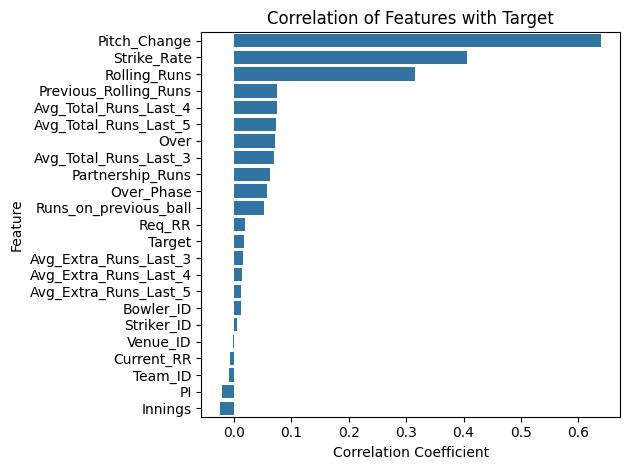

In [28]:
correlation_with_target = x.apply(lambda col: col.corr(y))
correlation_with_target = correlation_with_target.sort_values(ascending=False)

print("Correlation with Target:")
print(correlation_with_target)

sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)
plt.title("Correlation of Features with Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [29]:
mi_scores = mutual_info_classif(x, y, discrete_features='auto')
mi_scores_series = pd.Series(mi_scores, index=x.columns).sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_scores_series)


Mutual Information Scores:
Partnership_Runs         0.798682
Pitch_Change             0.747592
Strike_Rate              0.115303
Rolling_Runs             0.058271
Over                     0.026937
Over_Phase               0.026685
Striker_ID               0.021978
Bowler_ID                0.012085
Innings                  0.009829
Previous_Rolling_Runs    0.008082
Runs_on_previous_ball    0.004123
Avg_Extra_Runs_Last_4    0.003959
Avg_Total_Runs_Last_4    0.003401
Avg_Total_Runs_Last_5    0.003163
Req_RR                   0.001137
Avg_Total_Runs_Last_3    0.000278
Current_RR               0.000171
PI                       0.000000
Team_ID                  0.000000
Target                   0.000000
Avg_Extra_Runs_Last_3    0.000000
Avg_Extra_Runs_Last_5    0.000000
Venue_ID                 0.000000
dtype: float64


In [30]:
pps_scores = x.columns.to_series().apply(lambda col: pps.score(df, col, 'label_mapped')['ppscore'])
pps_scores = pps_scores.sort_values(ascending=False)
print("\nPPS Scores:")
print(pps_scores)


PPS Scores:
Pitch_Change             0.532949
Partnership_Runs         0.415935
Avg_Total_Runs_Last_5    0.000000
Previous_Rolling_Runs    0.000000
Rolling_Runs             0.000000
PI                       0.000000
Req_RR                   0.000000
Current_RR               0.000000
Target                   0.000000
Innings                  0.000000
Over_Phase               0.000000
Over                     0.000000
Bowler_ID                0.000000
Avg_Total_Runs_Last_3    0.000000
Avg_Extra_Runs_Last_3    0.000000
Avg_Extra_Runs_Last_4    0.000000
Avg_Extra_Runs_Last_5    0.000000
Runs_on_previous_ball    0.000000
Strike_Rate              0.000000
Team_ID                  0.000000
Venue_ID                 0.000000
Striker_ID               0.000000
Avg_Total_Runs_Last_4    0.000000
dtype: float64


In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [32]:
train_loader = DataLoader(CricketDataset(x_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(CricketDataset(x_test, y_test), batch_size=64, shuffle=False)

In [33]:
print("x_train dtype:\n", x_train.dtypes)
print("\ny_train dtype:\n", y_train.dtype)

x_train dtype:
 Over                     float64
Bowler_ID                  int64
Striker_ID                 int64
Venue_ID                   int64
Team_ID                    int64
Strike_Rate              float64
Runs_on_previous_ball      int64
Avg_Extra_Runs_Last_5    float64
Avg_Extra_Runs_Last_4    float64
Avg_Extra_Runs_Last_3    float64
Avg_Total_Runs_Last_3    float64
Avg_Total_Runs_Last_4    float64
Avg_Total_Runs_Last_5    float64
Over_Phase                 int64
Partnership_Runs           int64
Innings                    int64
Target                     int64
Current_RR               float64
Req_RR                   float64
PI                       float64
Rolling_Runs             float64
Previous_Rolling_Runs    float64
Pitch_Change             float64
dtype: object

y_train dtype:
 int64


In [34]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

print(x_train.dtypes)
print("\n",x_test.dtypes)

Over                     float32
Bowler_ID                float32
Striker_ID               float32
Venue_ID                 float32
Team_ID                  float32
Strike_Rate              float32
Runs_on_previous_ball    float32
Avg_Extra_Runs_Last_5    float32
Avg_Extra_Runs_Last_4    float32
Avg_Extra_Runs_Last_3    float32
Avg_Total_Runs_Last_3    float32
Avg_Total_Runs_Last_4    float32
Avg_Total_Runs_Last_5    float32
Over_Phase               float32
Partnership_Runs         float32
Innings                  float32
Target                   float32
Current_RR               float32
Req_RR                   float32
PI                       float32
Rolling_Runs             float32
Previous_Rolling_Runs    float32
Pitch_Change             float32
dtype: object

 Over                     float32
Bowler_ID                float32
Striker_ID               float32
Venue_ID                 float32
Team_ID                  float32
Strike_Rate              float32
Runs_on_previous_ball    fl

In [35]:
model_dict = {
    "Linear": LinearModel,
    "CNN": CNNModel,
    "RNN": RNNModel,
    "LSTM": LSTMModel,
    "GRU": GRUModel,
    "BiLSTM": BiLSTMModel,
    "Transformer": TransformerModel,
}

In [36]:
model_dict1 = {
    "Linear": LinearModel1,
    "CNN": CNNModel1,
    "RNN": RNNModel1,
    "LSTM": LSTMModel1,
    "GRU": GRUModel1,
    "BiLSTM": BiLSTMModel1,
    "Transformer": TransformerModel1,
}

In [37]:
for name, model_cls in model_dict.items():
    print(f"\n{'='*30}\nCreating {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5)
    print(model)


Creating Linear Model
LinearModel(
  (fc): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
)

Creating CNN Model
CNNModel(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): AdaptiveAvgPool1d(output_size=1)
  )
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

Creating RNN Model
RNNModel(
  (rnn): RNN(23, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

Creating LSTM Model
LSTMModel(
  (lstm): LSTM(23, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

Creating GRU Model
GRUModel(
  (gru): GRU(23, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

Creating

c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [38]:
for name, model_cls in model_dict1.items():
    print(f"\n{'='*30}\nCreating {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5)
    print(model)


Creating Linear Model
LinearModel1(
  (fc): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=5, bias=True)
  )
)

Creating CNN Model
CNNModel1(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): AdaptiveAvgPool1d(output_size=1)
  )
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

Creating RNN Model
RNNModel1(
  (rnn): RNN(23, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

Creating LSTM Model
LSTMModel1(
  (lstm): LSTM(23, 64, num_layers=2, batch_first=True)
  (fc


Training Linear Model
Epoch 1, Train Loss: 1.4555, Test Loss: 1.0721
Epoch 5, Train Loss: 0.5358, Test Loss: 0.5121
Epoch 10, Train Loss: 0.3863, Test Loss: 0.3755
Epoch 15, Train Loss: 0.3193, Test Loss: 0.3287
Epoch 20, Train Loss: 0.3017, Test Loss: 0.3625
Epoch 25, Train Loss: 0.2778, Test Loss: 0.2902
Epoch 30, Train Loss: 0.2514, Test Loss: 0.2782
Epoch 35, Train Loss: 0.2335, Test Loss: 0.2681
Epoch 40, Train Loss: 0.2226, Test Loss: 0.2344
Epoch 45, Train Loss: 0.2164, Test Loss: 0.2195
Epoch 50, Train Loss: 0.2090, Test Loss: 0.2046

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.90      0.96      0.93      3645
           2       0.73      0.49      0.59       565
           4       0.89      0.86      0.87      1098
           6       0.93      0.88      0.91       590

    accuracy                           0.93      8694
   macro avg       0.89      0.84      0.86    

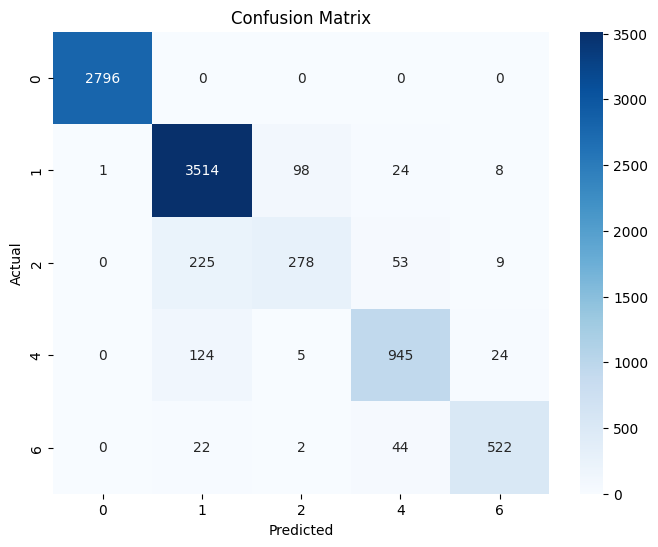

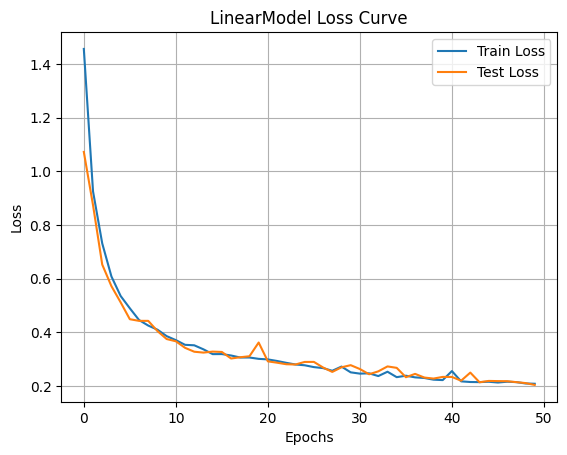

Time taken: 80.72 sec

Training CNN Model
Epoch 1, Train Loss: 1.6074, Test Loss: 1.3596
Epoch 5, Train Loss: 0.9274, Test Loss: 0.8887
Epoch 10, Train Loss: 0.6518, Test Loss: 0.6209
Epoch 15, Train Loss: 0.5427, Test Loss: 0.6755
Epoch 20, Train Loss: 0.5054, Test Loss: 0.4929
Epoch 25, Train Loss: 0.4678, Test Loss: 0.6197
Epoch 30, Train Loss: 0.4425, Test Loss: 0.4533
Epoch 35, Train Loss: 0.4249, Test Loss: 0.4207
Epoch 40, Train Loss: 0.3936, Test Loss: 0.4018
Epoch 45, Train Loss: 0.3910, Test Loss: 0.3880
Epoch 50, Train Loss: 0.3703, Test Loss: 0.3784

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.86      0.98      0.92      3645
           2       0.76      0.05      0.10       565
           4       0.67      0.78      0.72      1098
           6       0.84      0.61      0.70       590

    accuracy                           0.88      8694
   macro avg       0.83     

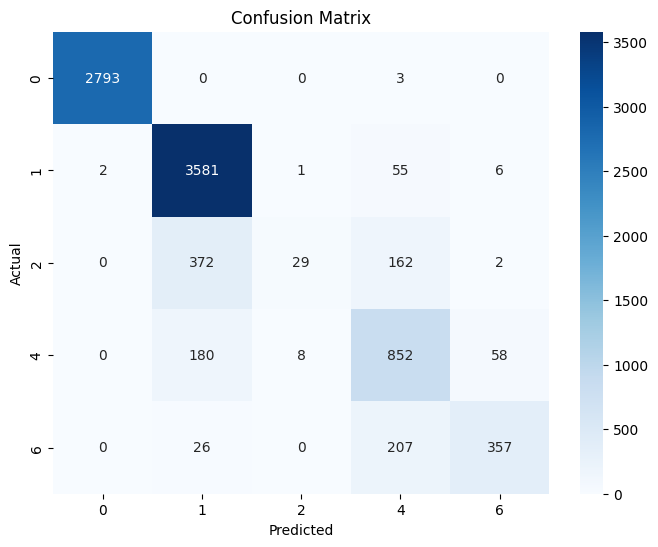

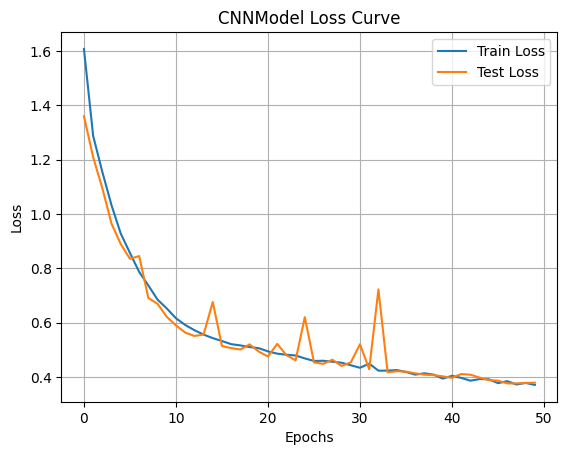

Time taken: 84.57 sec

Training RNN Model
Epoch 1, Train Loss: 1.3684, Test Loss: 1.3482
Epoch 5, Train Loss: 0.6626, Test Loss: 0.6534
Epoch 10, Train Loss: 0.4557, Test Loss: 0.4508
Epoch 15, Train Loss: 0.3971, Test Loss: 0.3890
Epoch 20, Train Loss: 0.3810, Test Loss: 0.3769
Epoch 25, Train Loss: 0.3719, Test Loss: 0.3684
Epoch 30, Train Loss: 0.3625, Test Loss: 0.3716
Epoch 35, Train Loss: 0.3622, Test Loss: 0.3573
Epoch 40, Train Loss: 0.3564, Test Loss: 0.3538
Epoch 45, Train Loss: 0.3512, Test Loss: 0.3548
Epoch 50, Train Loss: 0.3517, Test Loss: 0.3510

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.81      1.00      0.90      3645
           2       0.83      0.08      0.15       565
           4       0.81      0.57      0.67      1098
           6       0.68      0.69      0.69       590

    accuracy                           0.86      8694
   macro avg       0.83     

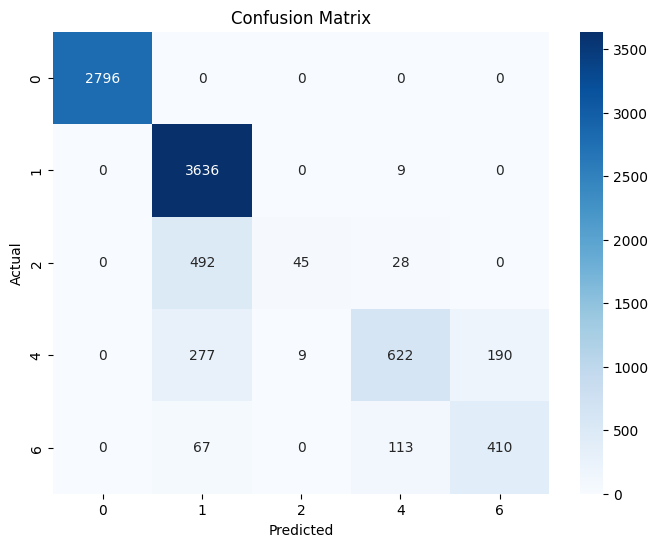

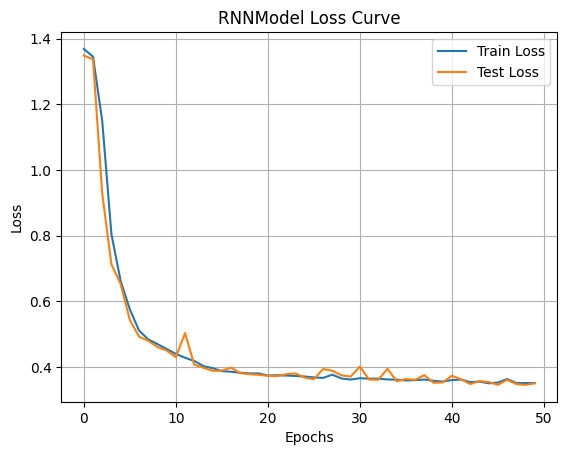

Time taken: 79.49 sec

Training LSTM Model
Epoch 1, Train Loss: 1.3352, Test Loss: 1.2245
Epoch 5, Train Loss: 0.5617, Test Loss: 0.5391
Epoch 10, Train Loss: 0.4181, Test Loss: 0.4099
Epoch 15, Train Loss: 0.3595, Test Loss: 0.3533
Epoch 20, Train Loss: 0.3153, Test Loss: 0.3109
Epoch 25, Train Loss: 0.2891, Test Loss: 0.2924
Epoch 30, Train Loss: 0.2748, Test Loss: 0.2834
Epoch 35, Train Loss: 0.2664, Test Loss: 0.2613
Epoch 40, Train Loss: 0.2557, Test Loss: 0.2566
Epoch 45, Train Loss: 0.2549, Test Loss: 0.2595
Epoch 50, Train Loss: 0.2540, Test Loss: 0.2445

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.87      0.98      0.92      3645
           2       0.80      0.30      0.43       565
           4       0.88      0.83      0.85      1098
           6       0.91      0.84      0.88       590

    accuracy                           0.91      8694
   macro avg       0.89    

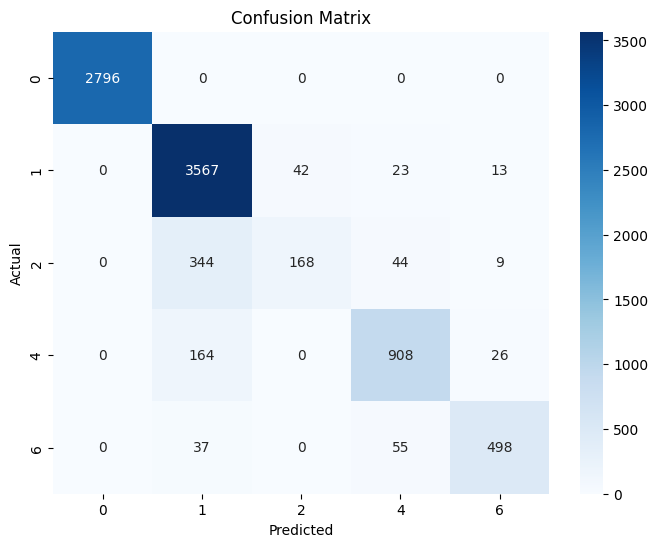

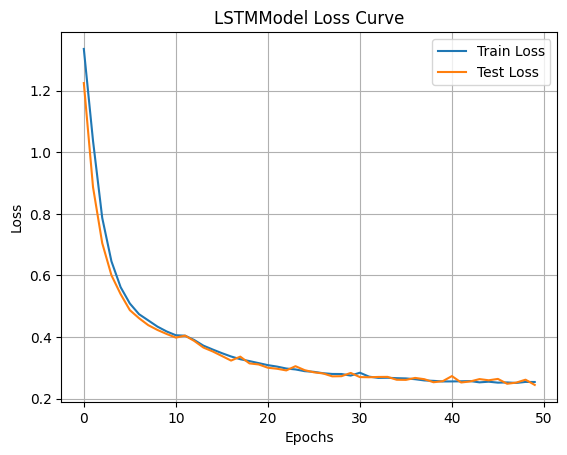

Time taken: 82.31 sec

Training GRU Model
Epoch 1, Train Loss: 1.3492, Test Loss: 1.2754
Epoch 5, Train Loss: 0.5913, Test Loss: 0.5534
Epoch 10, Train Loss: 0.4137, Test Loss: 0.4068
Epoch 15, Train Loss: 0.3421, Test Loss: 0.3274
Epoch 20, Train Loss: 0.3061, Test Loss: 0.3117
Epoch 25, Train Loss: 0.2831, Test Loss: 0.2813
Epoch 30, Train Loss: 0.2742, Test Loss: 0.2822
Epoch 35, Train Loss: 0.2663, Test Loss: 0.2581
Epoch 40, Train Loss: 0.2589, Test Loss: 0.2588
Epoch 45, Train Loss: 0.2508, Test Loss: 0.2477
Epoch 50, Train Loss: 0.2486, Test Loss: 0.2396

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.88      0.98      0.93      3645
           2       0.79      0.36      0.50       565
           4       0.82      0.83      0.83      1098
           6       0.91      0.76      0.83       590

    accuracy                           0.91      8694
   macro avg       0.88     

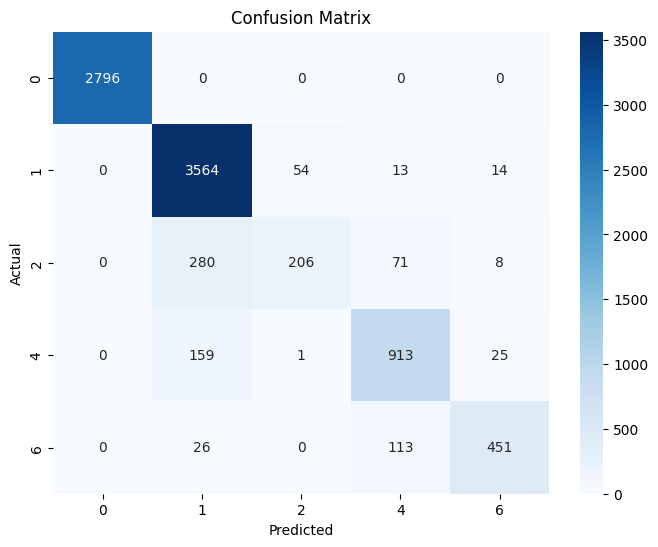

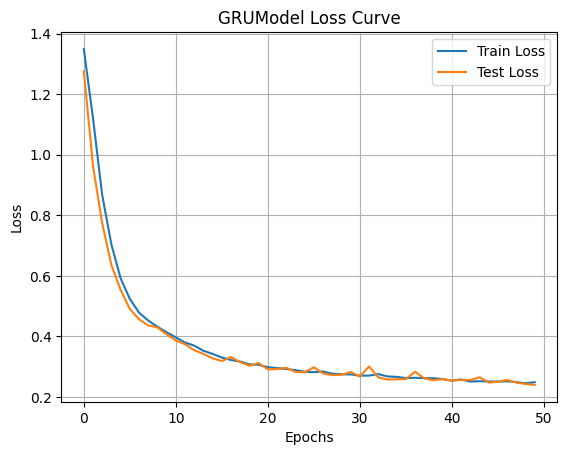

Time taken: 77.94 sec

Training BiLSTM Model
Epoch 1, Train Loss: 1.3288, Test Loss: 1.2353
Epoch 5, Train Loss: 0.5268, Test Loss: 0.4992
Epoch 10, Train Loss: 0.3831, Test Loss: 0.3952
Epoch 15, Train Loss: 0.3240, Test Loss: 0.3163
Epoch 20, Train Loss: 0.2888, Test Loss: 0.2844
Epoch 25, Train Loss: 0.2696, Test Loss: 0.2649
Epoch 30, Train Loss: 0.2582, Test Loss: 0.2734
Epoch 35, Train Loss: 0.2482, Test Loss: 0.2391
Epoch 40, Train Loss: 0.2368, Test Loss: 0.2370
Epoch 45, Train Loss: 0.2350, Test Loss: 0.2272
Epoch 50, Train Loss: 0.2275, Test Loss: 0.2273

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.87      0.99      0.93      3645
           2       0.84      0.41      0.56       565
           4       0.90      0.80      0.85      1098
           6       0.96      0.84      0.89       590

    accuracy                           0.92      8694
   macro avg       0.92  

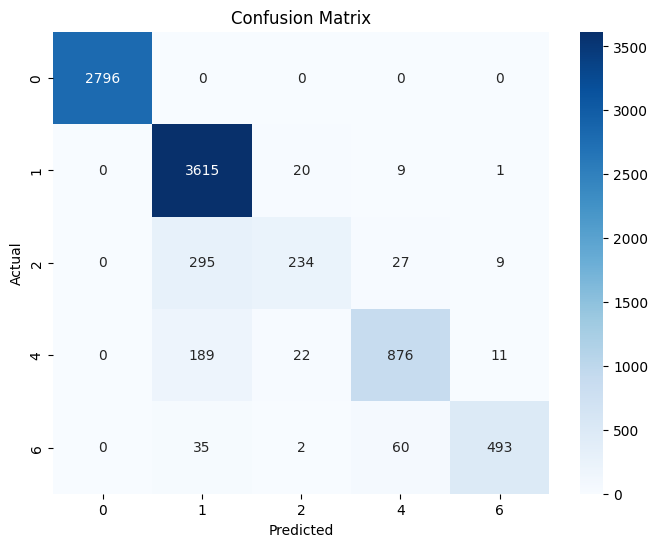

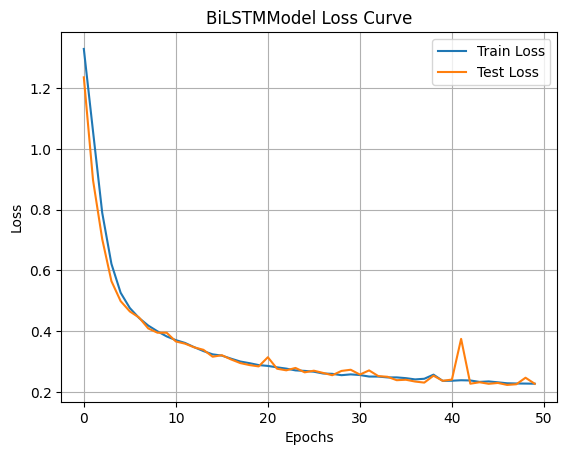

Time taken: 79.96 sec

Training Transformer Model


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Train Loss: 1.3657, Test Loss: 1.3489
Epoch 5, Train Loss: 0.9099, Test Loss: 0.8723
Epoch 10, Train Loss: 0.7237, Test Loss: 0.5807
Epoch 15, Train Loss: 0.4730, Test Loss: 0.4029
Epoch 20, Train Loss: 0.3805, Test Loss: 0.3225
Epoch 25, Train Loss: 0.3127, Test Loss: 0.2468
Epoch 30, Train Loss: 0.3068, Test Loss: 0.2601
Epoch 35, Train Loss: 0.2910, Test Loss: 0.2446
Epoch 40, Train Loss: 0.2637, Test Loss: 0.2311
Epoch 45, Train Loss: 0.2600, Test Loss: 0.2418
Epoch 50, Train Loss: 0.2756, Test Loss: 0.4057

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2796
           1       0.77      1.00      0.87      3645
           2       0.41      0.12      0.19       565
           4       0.85      0.68      0.76      1098
           6       0.97      0.59      0.73       590

    accuracy                           0.84      8694
   macro avg       0.80      0.66      0.70      8694
weighted avg    

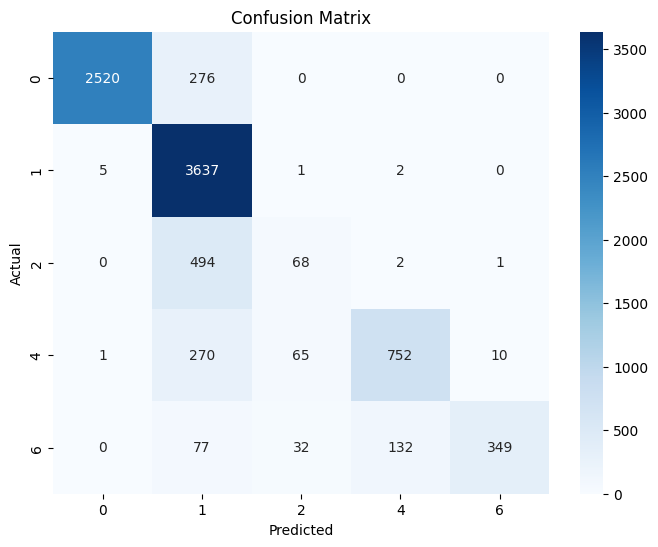

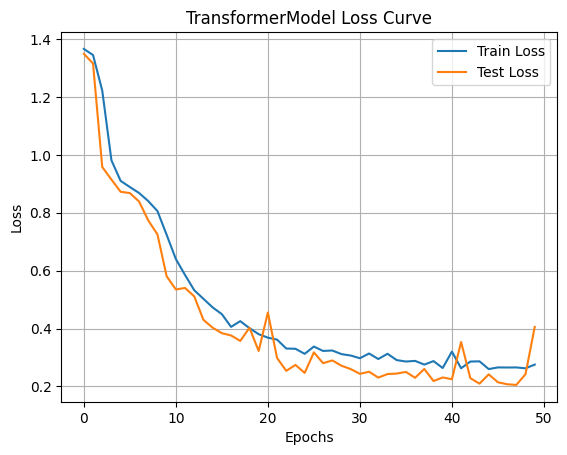

Time taken: 198.09 sec


In [40]:
for name, model_cls in model_dict.items():
    print(f"\n{'='*30}\nTraining {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5).to(device)
    start_time = time.time()
    train_and_evaluate(model, train_loader, test_loader)
    print(f"Time taken: {time.time() - start_time:.2f} sec")


Training Linear Model
Epoch 1, Train Loss: 1.4032, Test Loss: 1.1274
Epoch 5, Train Loss: 0.6137, Test Loss: 0.5818
Epoch 10, Train Loss: 0.4082, Test Loss: 0.3907
Epoch 15, Train Loss: 0.3389, Test Loss: 0.3279
Epoch 20, Train Loss: 0.3092, Test Loss: 0.3477
Epoch 25, Train Loss: 0.3046, Test Loss: 0.2929
Epoch 30, Train Loss: 0.2908, Test Loss: 0.2933
Epoch 35, Train Loss: 0.2783, Test Loss: 0.2713
Epoch 40, Train Loss: 0.2622, Test Loss: 0.2572
Epoch 45, Train Loss: 0.2542, Test Loss: 0.2599
Epoch 50, Train Loss: 0.2350, Test Loss: 0.2502
Epoch 55, Train Loss: 0.2395, Test Loss: 0.2933
Epoch 60, Train Loss: 0.2291, Test Loss: 0.2177
Epoch 65, Train Loss: 0.2072, Test Loss: 0.2443
Epoch 70, Train Loss: 0.2113, Test Loss: 0.1931
Epoch 75, Train Loss: 0.1972, Test Loss: 0.1942
Epoch 80, Train Loss: 0.1980, Test Loss: 0.2018
Epoch 85, Train Loss: 0.1906, Test Loss: 0.1890
Epoch 90, Train Loss: 0.1963, Test Loss: 0.1904
Epoch 95, Train Loss: 0.1934, Test Loss: 0.1847
Epoch 100, Train Lo

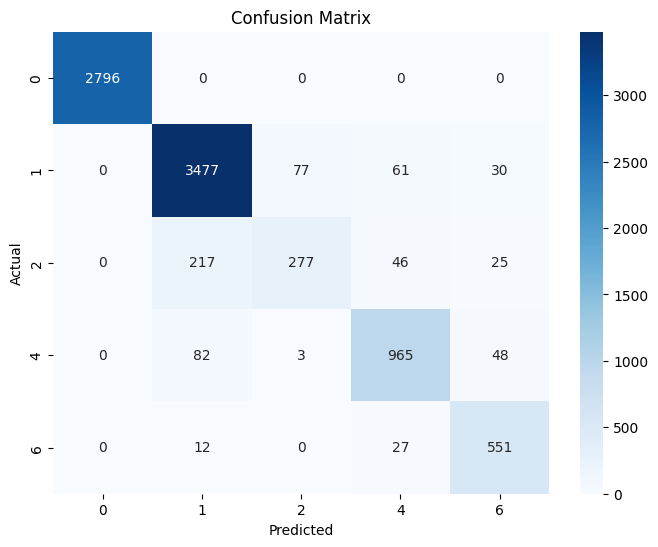

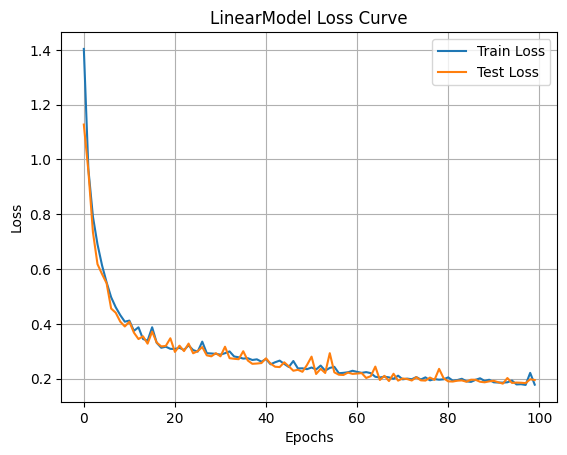

Time taken: 158.06 sec

Training CNN Model
Epoch 1, Train Loss: 1.4103, Test Loss: 1.2651
Epoch 5, Train Loss: 0.7794, Test Loss: 0.7861
Epoch 10, Train Loss: 0.5377, Test Loss: 0.5256
Epoch 15, Train Loss: 0.4736, Test Loss: 0.4734
Epoch 20, Train Loss: 0.4368, Test Loss: 0.4273
Epoch 25, Train Loss: 0.4133, Test Loss: 0.4311
Epoch 30, Train Loss: 0.3840, Test Loss: 0.4065
Epoch 35, Train Loss: 0.3703, Test Loss: 0.3762
Epoch 40, Train Loss: 0.3599, Test Loss: 0.3754
Epoch 45, Train Loss: 0.3423, Test Loss: 0.3389
Epoch 50, Train Loss: 0.3319, Test Loss: 0.3450
Epoch 55, Train Loss: 0.3158, Test Loss: 0.3147
Epoch 60, Train Loss: 0.3201, Test Loss: 0.3484
Epoch 65, Train Loss: 0.3024, Test Loss: 0.3200
Epoch 70, Train Loss: 0.2952, Test Loss: 0.2890
Epoch 75, Train Loss: 0.2843, Test Loss: 0.2877
Epoch 80, Train Loss: 0.2778, Test Loss: 0.2874
Epoch 85, Train Loss: 0.2815, Test Loss: 0.2817
Epoch 90, Train Loss: 0.2621, Test Loss: 0.3040
Epoch 95, Train Loss: 0.2610, Test Loss: 0.2754

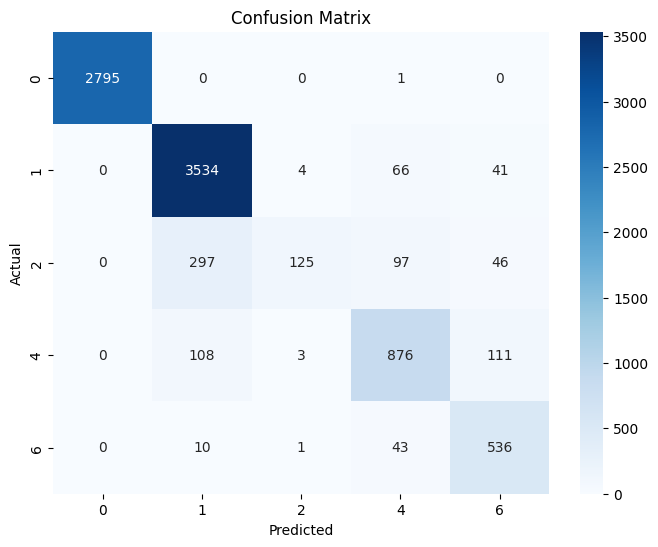

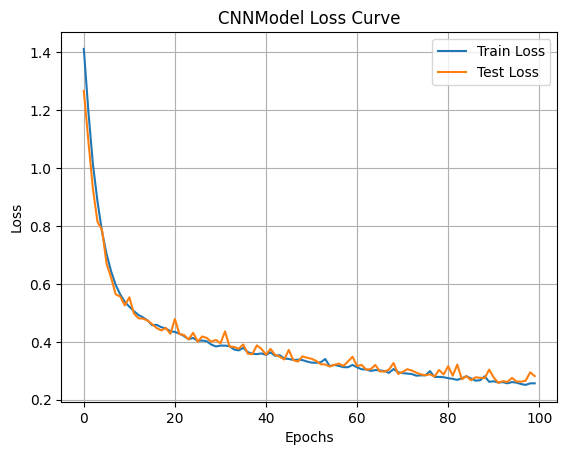

Time taken: 190.80 sec

Training RNN Model
Epoch 1, Train Loss: 1.3704, Test Loss: 1.3293
Epoch 5, Train Loss: 0.6246, Test Loss: 0.5675
Epoch 10, Train Loss: 0.3995, Test Loss: 0.3944
Epoch 15, Train Loss: 0.3317, Test Loss: 0.3143
Epoch 20, Train Loss: 0.3155, Test Loss: 0.3107
Epoch 25, Train Loss: 0.2786, Test Loss: 0.2688
Epoch 30, Train Loss: 0.2592, Test Loss: 0.2540
Epoch 35, Train Loss: 0.2551, Test Loss: 0.2571
Epoch 40, Train Loss: 0.2534, Test Loss: 0.2510
Epoch 45, Train Loss: 0.2560, Test Loss: 0.2578
Epoch 50, Train Loss: 0.2511, Test Loss: 0.2471
Epoch 55, Train Loss: 0.2491, Test Loss: 0.2648
Epoch 60, Train Loss: 0.2504, Test Loss: 0.2411
Epoch 65, Train Loss: 0.2461, Test Loss: 0.2539
Epoch 70, Train Loss: 0.2473, Test Loss: 0.2483
Epoch 75, Train Loss: 0.2462, Test Loss: 0.2477
Epoch 80, Train Loss: 0.2496, Test Loss: 0.2480
Epoch 85, Train Loss: 0.2462, Test Loss: 0.2415
Epoch 90, Train Loss: 0.2443, Test Loss: 0.2418
Epoch 95, Train Loss: 0.2462, Test Loss: 0.2336

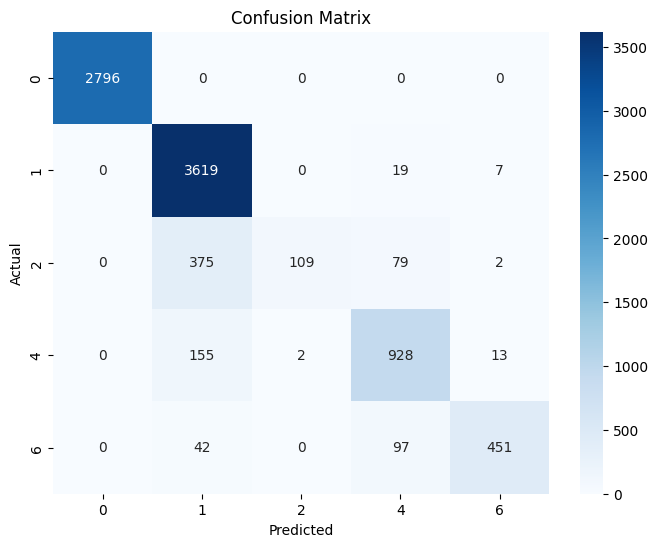

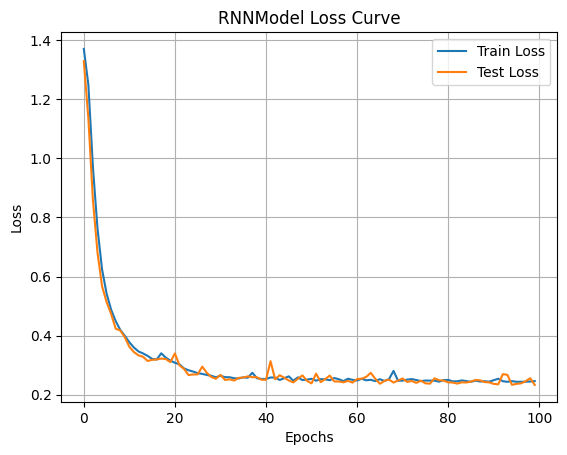

Time taken: 209.37 sec

Training LSTM Model
Epoch 1, Train Loss: 1.3473, Test Loss: 1.2852
Epoch 5, Train Loss: 0.6867, Test Loss: 0.6411
Epoch 10, Train Loss: 0.4361, Test Loss: 0.4401
Epoch 15, Train Loss: 0.3757, Test Loss: 0.3755
Epoch 20, Train Loss: 0.3355, Test Loss: 0.3425
Epoch 25, Train Loss: 0.2983, Test Loss: 0.3011
Epoch 30, Train Loss: 0.2722, Test Loss: 0.2730
Epoch 35, Train Loss: 0.2574, Test Loss: 0.3046
Epoch 40, Train Loss: 0.2442, Test Loss: 0.2520
Epoch 45, Train Loss: 0.2348, Test Loss: 0.2339
Epoch 50, Train Loss: 0.2391, Test Loss: 0.2394
Epoch 55, Train Loss: 0.2254, Test Loss: 0.2266
Epoch 60, Train Loss: 0.2208, Test Loss: 0.2137
Epoch 65, Train Loss: 0.2161, Test Loss: 0.2077
Epoch 70, Train Loss: 0.2147, Test Loss: 0.2309
Epoch 75, Train Loss: 0.2109, Test Loss: 0.2324
Epoch 80, Train Loss: 0.2115, Test Loss: 0.2265
Epoch 85, Train Loss: 0.2074, Test Loss: 0.2102
Epoch 90, Train Loss: 0.2058, Test Loss: 0.1974
Epoch 95, Train Loss: 0.2062, Test Loss: 0.205

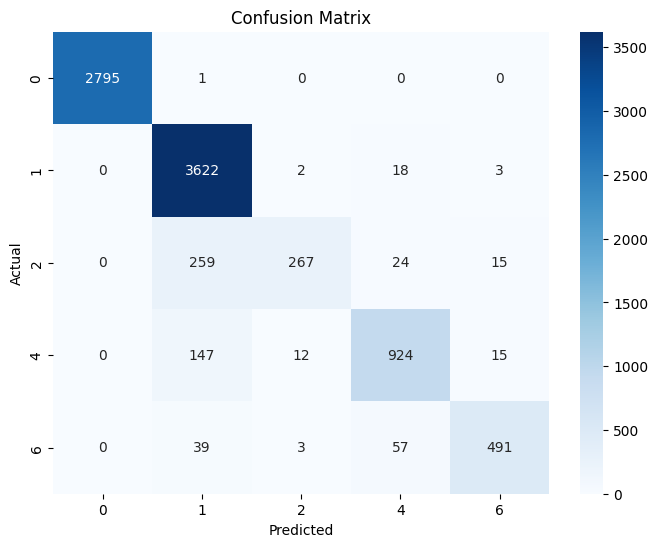

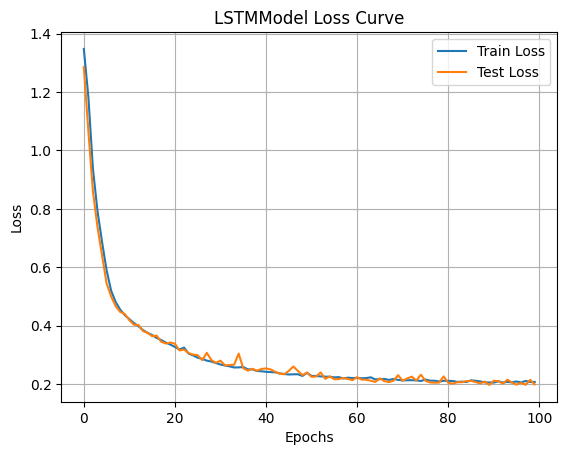

Time taken: 195.88 sec

Training GRU Model
Epoch 1, Train Loss: 1.3636, Test Loss: 1.3278
Epoch 5, Train Loss: 0.6244, Test Loss: 0.5697
Epoch 10, Train Loss: 0.4100, Test Loss: 0.4096
Epoch 15, Train Loss: 0.3357, Test Loss: 0.3239
Epoch 20, Train Loss: 0.2863, Test Loss: 0.2746
Epoch 25, Train Loss: 0.2658, Test Loss: 0.2634
Epoch 30, Train Loss: 0.2575, Test Loss: 0.2496
Epoch 35, Train Loss: 0.2438, Test Loss: 0.2698
Epoch 40, Train Loss: 0.2414, Test Loss: 0.2578
Epoch 45, Train Loss: 0.2363, Test Loss: 0.2305
Epoch 50, Train Loss: 0.2305, Test Loss: 0.2262
Epoch 55, Train Loss: 0.2272, Test Loss: 0.2251
Epoch 60, Train Loss: 0.2311, Test Loss: 0.2236
Epoch 65, Train Loss: 0.2210, Test Loss: 0.2310
Epoch 70, Train Loss: 0.2250, Test Loss: 0.2173
Epoch 75, Train Loss: 0.2192, Test Loss: 0.2377
Epoch 80, Train Loss: 0.2256, Test Loss: 0.2243
Epoch 85, Train Loss: 0.2200, Test Loss: 0.2217
Epoch 90, Train Loss: 0.2143, Test Loss: 0.2216
Epoch 95, Train Loss: 0.2159, Test Loss: 0.2169

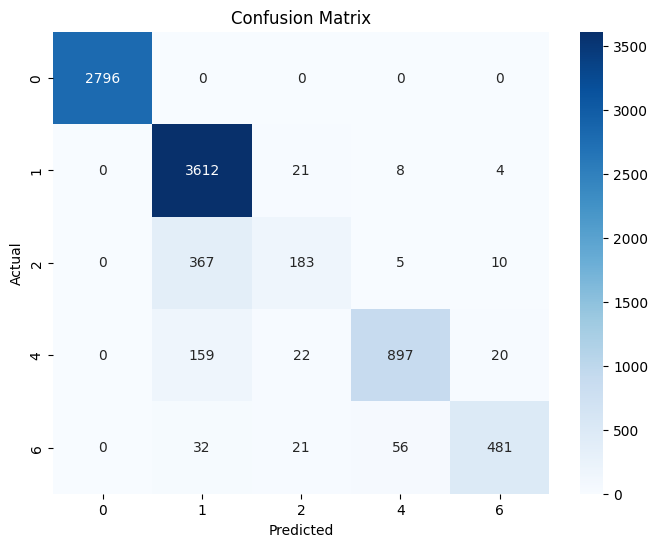

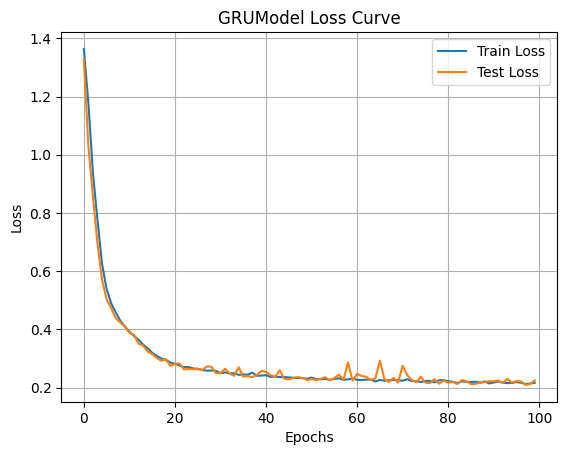

Time taken: 188.93 sec

Training BiLSTM Model
Epoch 1, Train Loss: 1.3462, Test Loss: 1.2768
Epoch 5, Train Loss: 0.5743, Test Loss: 0.5356
Epoch 10, Train Loss: 0.4003, Test Loss: 0.3969
Epoch 15, Train Loss: 0.3388, Test Loss: 0.3403
Epoch 20, Train Loss: 0.2998, Test Loss: 0.2927
Epoch 25, Train Loss: 0.2725, Test Loss: 0.2746
Epoch 30, Train Loss: 0.2565, Test Loss: 0.2596
Epoch 35, Train Loss: 0.2462, Test Loss: 0.2516
Epoch 40, Train Loss: 0.2352, Test Loss: 0.2322
Epoch 45, Train Loss: 0.2266, Test Loss: 0.2317
Epoch 50, Train Loss: 0.2230, Test Loss: 0.2187
Epoch 55, Train Loss: 0.2137, Test Loss: 0.2227
Epoch 60, Train Loss: 0.2069, Test Loss: 0.2047
Epoch 65, Train Loss: 0.2043, Test Loss: 0.2003
Epoch 70, Train Loss: 0.2031, Test Loss: 0.2019
Epoch 75, Train Loss: 0.1961, Test Loss: 0.2057
Epoch 80, Train Loss: 0.1938, Test Loss: 0.1938
Epoch 85, Train Loss: 0.1936, Test Loss: 0.1984
Epoch 90, Train Loss: 0.1940, Test Loss: 0.1989
Epoch 95, Train Loss: 0.1881, Test Loss: 0.1

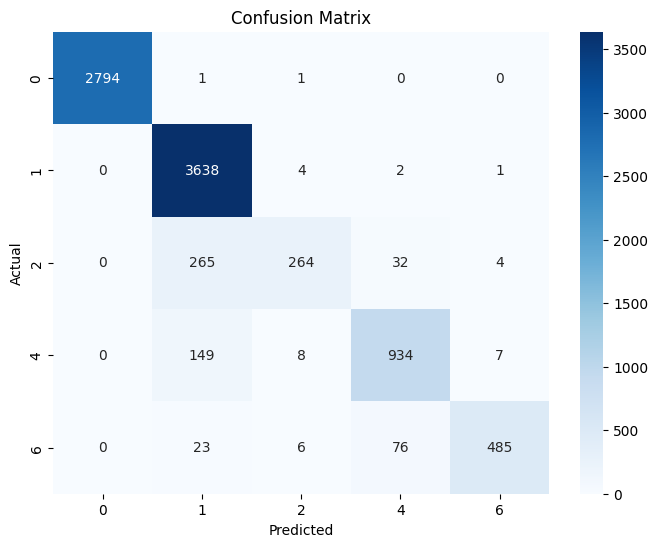

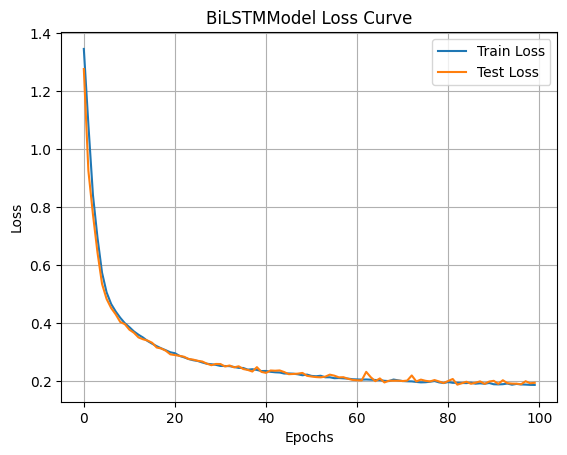

Time taken: 208.58 sec

Training Transformer Model


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Train Loss: 1.3665, Test Loss: 1.3461
Epoch 5, Train Loss: 0.9017, Test Loss: 0.8323
Epoch 10, Train Loss: 0.7622, Test Loss: 0.6396
Epoch 15, Train Loss: 0.4635, Test Loss: 0.4008
Epoch 20, Train Loss: 0.4008, Test Loss: 0.3389
Epoch 25, Train Loss: 0.3558, Test Loss: 0.2754
Epoch 30, Train Loss: 0.3486, Test Loss: 0.2618
Epoch 35, Train Loss: 0.3175, Test Loss: 0.2684
Epoch 40, Train Loss: 0.3155, Test Loss: 0.2929
Epoch 45, Train Loss: 0.3171, Test Loss: 0.2422
Epoch 50, Train Loss: 0.2729, Test Loss: 0.2270
Epoch 55, Train Loss: 0.2888, Test Loss: 0.2079
Epoch 60, Train Loss: 0.3152, Test Loss: 0.2178
Epoch 65, Train Loss: 0.2515, Test Loss: 0.2027
Epoch 70, Train Loss: 0.2838, Test Loss: 0.2034
Epoch 75, Train Loss: 0.2268, Test Loss: 0.2091
Epoch 80, Train Loss: 0.2798, Test Loss: 0.2059
Epoch 85, Train Loss: 0.2281, Test Loss: 0.1831
Epoch 90, Train Loss: 0.2132, Test Loss: 0.1847
Epoch 95, Train Loss: 0.2664, Test Loss: 0.1918
Epoch 100, Train Loss: 0.2148, Test Loss: 

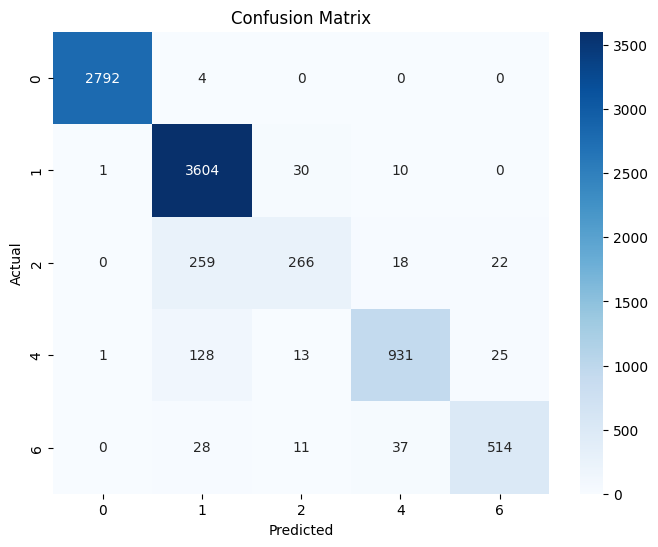

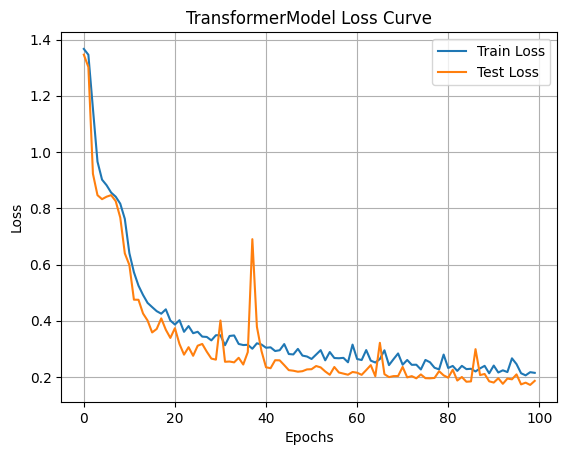

Time taken: 521.09 sec


In [41]:
for name, model_cls in model_dict.items():
    print(f"\n{'='*30}\nTraining {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5).to(device)
    start_time = time.time()
    train_and_evaluate1(model, train_loader, test_loader)
    print(f"Time taken: {time.time() - start_time:.2f} sec")


Training Linear Model
Epoch 1, Train Loss: 1.3301, Test Loss: 0.9964
Epoch 5, Train Loss: 0.4819, Test Loss: 0.4395
Epoch 10, Train Loss: 0.3634, Test Loss: 0.2942
Epoch 15, Train Loss: 0.2848, Test Loss: 0.3006
Epoch 20, Train Loss: 0.2650, Test Loss: 0.2429
Epoch 25, Train Loss: 0.2523, Test Loss: 0.2562
Epoch 30, Train Loss: 0.2585, Test Loss: 0.2142
Epoch 35, Train Loss: 0.2134, Test Loss: 0.2717
Epoch 40, Train Loss: 0.2124, Test Loss: 0.2085
Epoch 45, Train Loss: 0.2046, Test Loss: 0.1966
Epoch 50, Train Loss: 0.1987, Test Loss: 0.1869

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.90      0.97      0.93      3645
           2       0.72      0.54      0.62       565
           4       0.92      0.86      0.89      1098
           6       0.96      0.85      0.90       590

    accuracy                           0.93      8694
   macro avg       0.90      0.84      0.87    

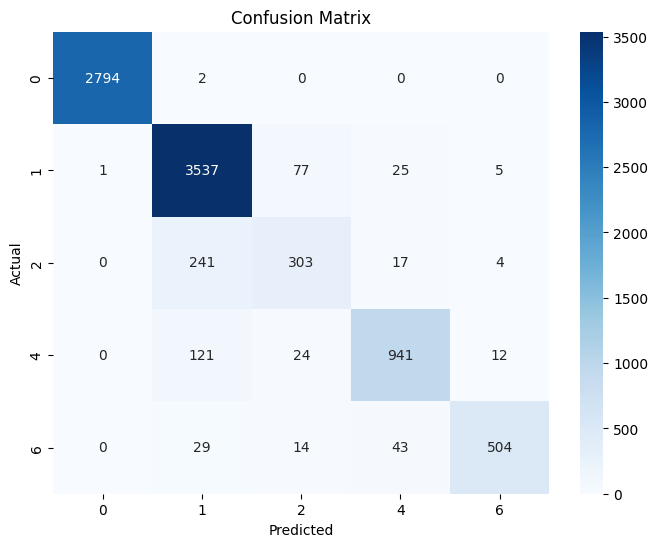

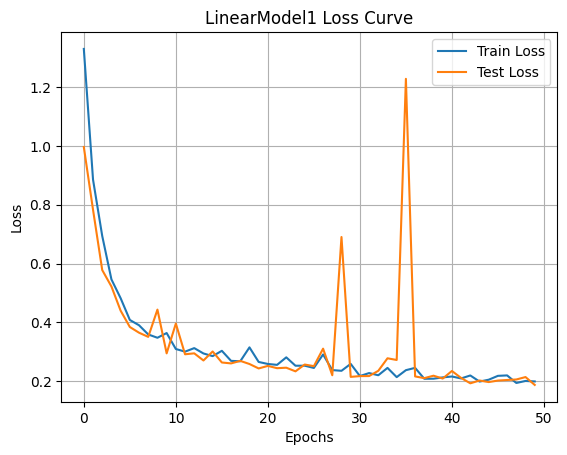

Time taken: 73.58 sec

Training CNN Model
Epoch 1, Train Loss: 1.3468, Test Loss: 1.2059
Epoch 5, Train Loss: 0.5165, Test Loss: 0.5016
Epoch 10, Train Loss: 0.3949, Test Loss: 0.3939
Epoch 15, Train Loss: 0.3193, Test Loss: 0.3614
Epoch 20, Train Loss: 0.2846, Test Loss: 0.2802
Epoch 25, Train Loss: 0.2616, Test Loss: 0.2522
Epoch 30, Train Loss: 0.2438, Test Loss: 0.2394
Epoch 35, Train Loss: 0.2243, Test Loss: 0.2238
Epoch 40, Train Loss: 0.2106, Test Loss: 0.2481
Epoch 45, Train Loss: 0.2029, Test Loss: 0.2215
Epoch 50, Train Loss: 0.1955, Test Loss: 0.2023

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.90      0.99      0.95      3645
           2       0.83      0.48      0.61       565
           4       0.91      0.86      0.88      1098
           6       0.95      0.86      0.90       590

    accuracy                           0.94      8694
   macro avg       0.92     

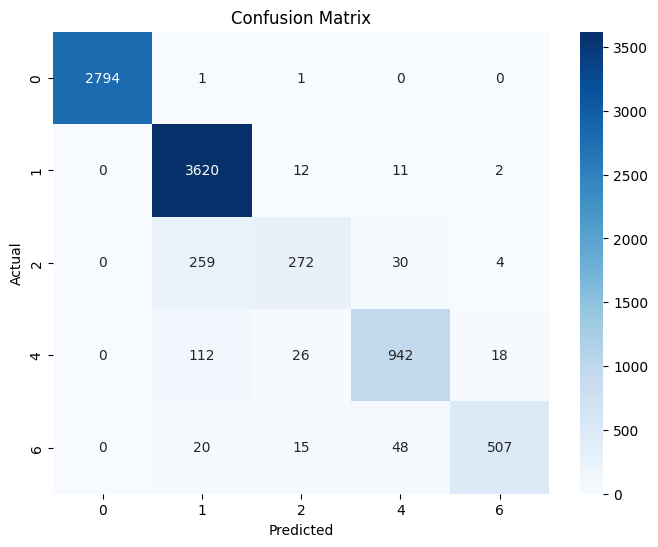

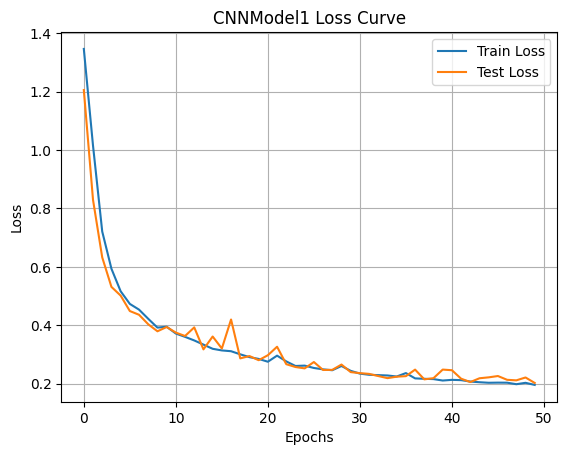

Time taken: 85.52 sec

Training RNN Model
Epoch 1, Train Loss: 1.1730, Test Loss: 0.8842
Epoch 5, Train Loss: 0.4110, Test Loss: 0.3975
Epoch 10, Train Loss: 0.3406, Test Loss: 0.3338
Epoch 15, Train Loss: 0.2942, Test Loss: 0.3103
Epoch 20, Train Loss: 0.2842, Test Loss: 0.2680
Epoch 25, Train Loss: 0.2978, Test Loss: 0.2724
Epoch 30, Train Loss: 0.2493, Test Loss: 0.2846
Epoch 35, Train Loss: 0.2423, Test Loss: 0.2793
Epoch 40, Train Loss: 0.2359, Test Loss: 0.2335
Epoch 45, Train Loss: 0.2433, Test Loss: 0.2219
Epoch 50, Train Loss: 0.2379, Test Loss: 0.2344

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.88      1.00      0.94      3645
           2       0.83      0.44      0.57       565
           4       0.84      0.72      0.78      1098
           6       0.84      0.78      0.81       590

    accuracy                           0.91      8694
   macro avg       0.88     

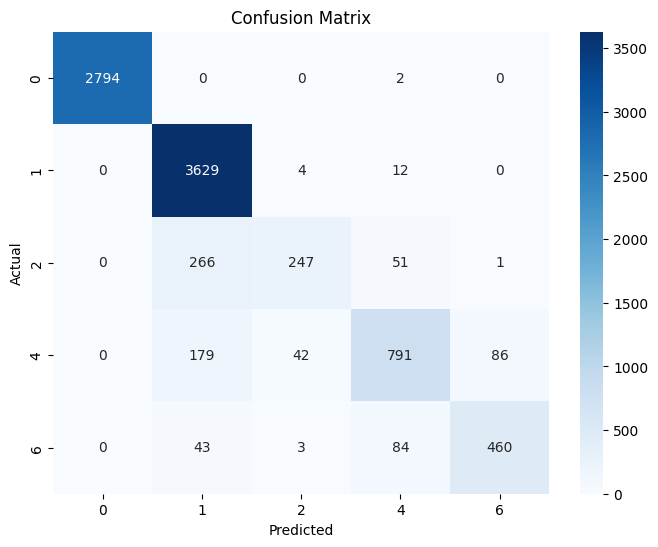

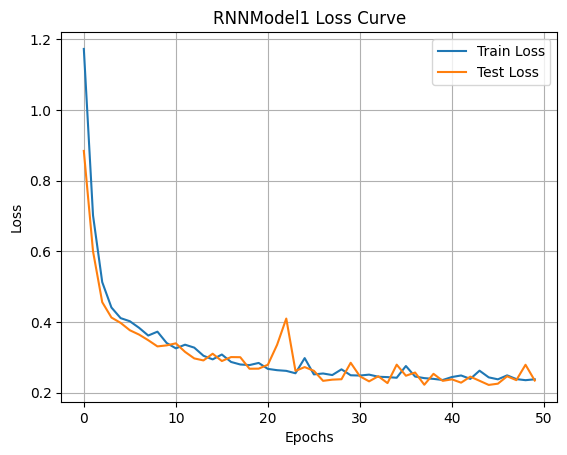

Time taken: 79.94 sec

Training LSTM Model
Epoch 1, Train Loss: 1.2442, Test Loss: 0.8733
Epoch 5, Train Loss: 0.3848, Test Loss: 0.3759
Epoch 10, Train Loss: 0.3098, Test Loss: 0.2955
Epoch 15, Train Loss: 0.2761, Test Loss: 0.2835
Epoch 20, Train Loss: 0.2547, Test Loss: 0.2548
Epoch 25, Train Loss: 0.2401, Test Loss: 0.2455
Epoch 30, Train Loss: 0.2267, Test Loss: 0.2361
Epoch 35, Train Loss: 0.2174, Test Loss: 0.2041
Epoch 40, Train Loss: 0.2237, Test Loss: 0.1968
Epoch 45, Train Loss: 0.2252, Test Loss: 0.2036
Epoch 50, Train Loss: 0.2123, Test Loss: 0.1954

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.89      1.00      0.94      3645
           2       0.94      0.49      0.64       565
           4       0.91      0.82      0.86      1098
           6       0.97      0.85      0.90       590

    accuracy                           0.93      8694
   macro avg       0.94    

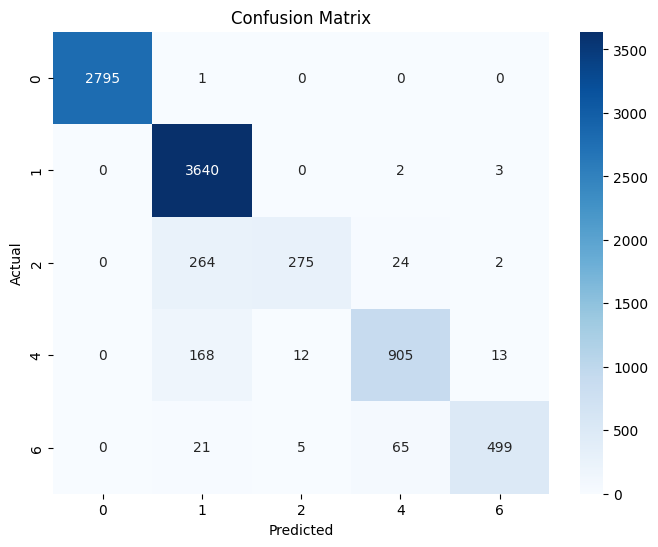

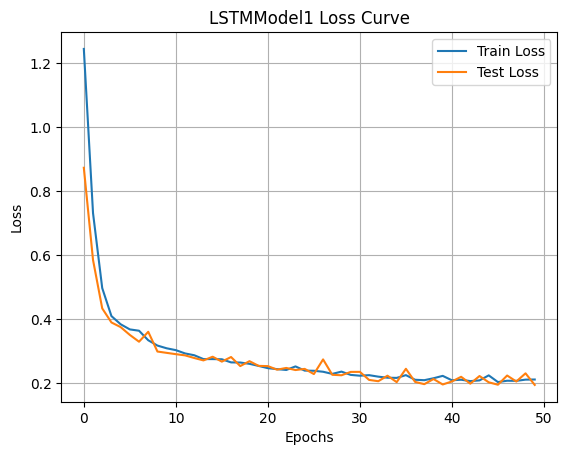

Time taken: 95.81 sec

Training GRU Model
Epoch 1, Train Loss: 1.1646, Test Loss: 0.8117
Epoch 5, Train Loss: 0.4129, Test Loss: 0.3789
Epoch 10, Train Loss: 0.3131, Test Loss: 0.3116
Epoch 15, Train Loss: 0.2825, Test Loss: 0.2626
Epoch 20, Train Loss: 0.2505, Test Loss: 0.2839
Epoch 25, Train Loss: 0.2442, Test Loss: 0.2618
Epoch 30, Train Loss: 0.2244, Test Loss: 0.2204
Epoch 35, Train Loss: 0.2190, Test Loss: 0.2013
Epoch 40, Train Loss: 0.2130, Test Loss: 0.2106
Epoch 45, Train Loss: 0.2048, Test Loss: 0.2348
Epoch 50, Train Loss: 0.1992, Test Loss: 0.1955

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.90      0.99      0.94      3645
           2       0.96      0.44      0.61       565
           4       0.92      0.86      0.89      1098
           6       0.86      0.91      0.88       590

    accuracy                           0.93      8694
   macro avg       0.93     

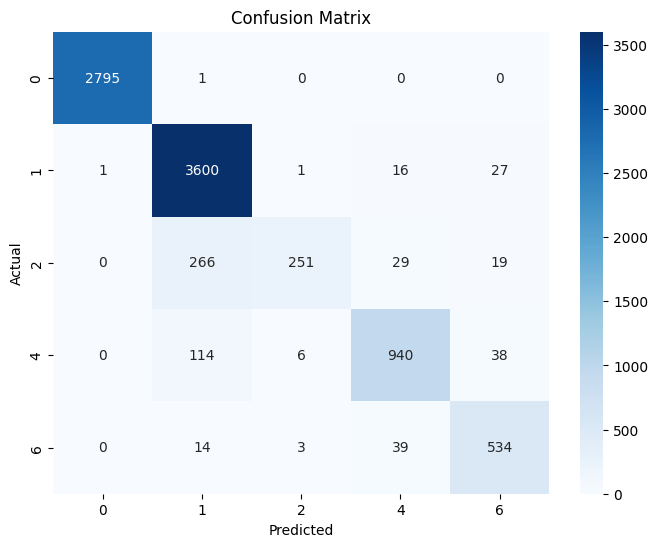

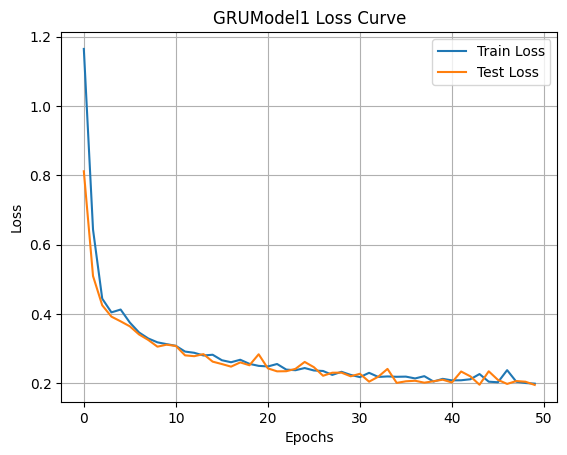

Time taken: 94.72 sec

Training BiLSTM Model
Epoch 1, Train Loss: 1.2452, Test Loss: 0.8938
Epoch 5, Train Loss: 0.3982, Test Loss: 0.3786
Epoch 10, Train Loss: 0.3194, Test Loss: 0.3175
Epoch 15, Train Loss: 0.2839, Test Loss: 0.2800
Epoch 20, Train Loss: 0.2637, Test Loss: 0.2833
Epoch 25, Train Loss: 0.2435, Test Loss: 0.2383
Epoch 30, Train Loss: 0.2347, Test Loss: 0.2426
Epoch 35, Train Loss: 0.2302, Test Loss: 0.2736
Epoch 40, Train Loss: 0.2206, Test Loss: 0.2149
Epoch 45, Train Loss: 0.2182, Test Loss: 0.2287
Epoch 50, Train Loss: 0.2132, Test Loss: 0.2134

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.90      0.97      0.94      3645
           2       0.76      0.54      0.63       565
           4       0.89      0.83      0.86      1098
           6       0.88      0.85      0.86       590

    accuracy                           0.93      8694
   macro avg       0.89  

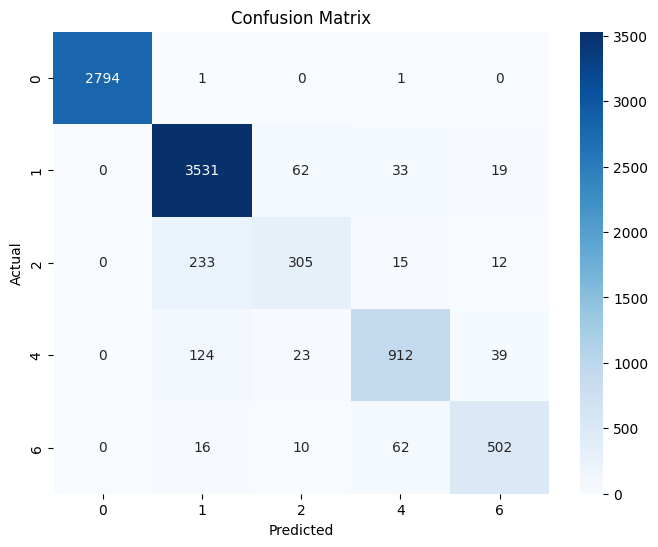

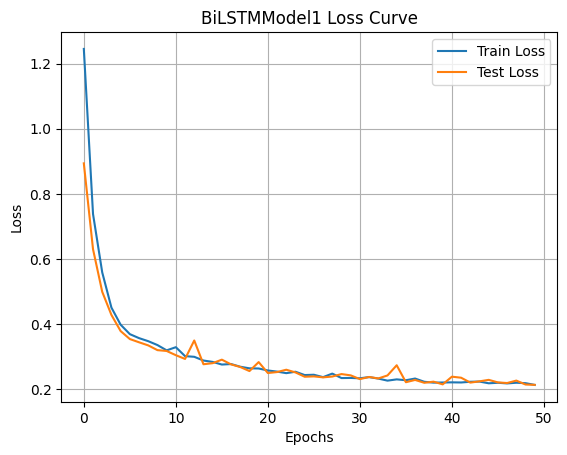

Time taken: 124.97 sec

Training Transformer Model


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Train Loss: 1.3546, Test Loss: 1.3488
Epoch 5, Train Loss: 0.7774, Test Loss: 0.6983
Epoch 10, Train Loss: 0.6154, Test Loss: 0.5164
Epoch 15, Train Loss: 0.5286, Test Loss: 0.5261
Epoch 20, Train Loss: 0.4999, Test Loss: 0.4759
Epoch 25, Train Loss: 0.4972, Test Loss: 0.4472
Epoch 30, Train Loss: 0.4829, Test Loss: 0.4336
Epoch 35, Train Loss: 0.4943, Test Loss: 0.3829
Epoch 40, Train Loss: 0.3544, Test Loss: 0.3505
Epoch 45, Train Loss: 0.3301, Test Loss: 0.2699
Epoch 50, Train Loss: 0.3059, Test Loss: 0.2601

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2796
           1       0.86      0.97      0.92      3645
           2       0.85      0.27      0.40       565
           4       0.83      0.77      0.80      1098
           6       0.85      0.86      0.85       590

    accuracy                           0.90      8694
   macro avg       0.88      0.77      0.79      8694
weighted avg    

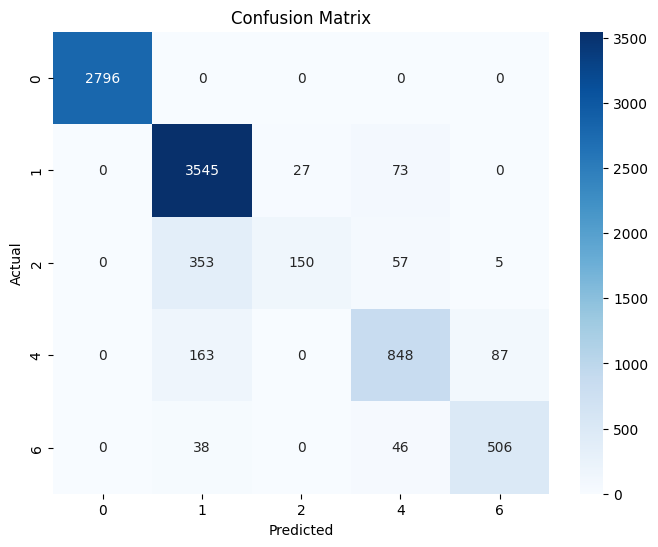

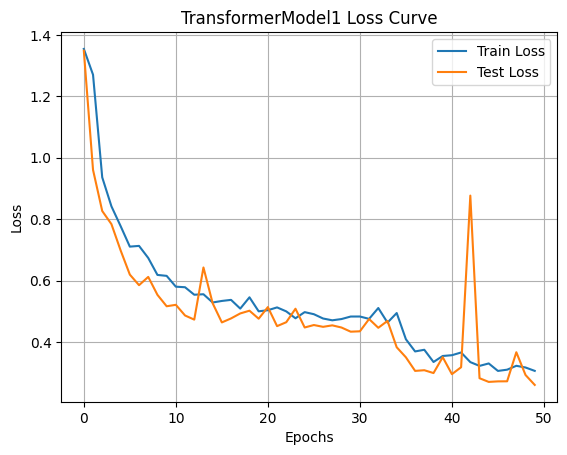

Time taken: 271.68 sec


In [42]:
for name, model_cls in model_dict1.items():
    print(f"\n{'='*30}\nTraining {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5).to(device)
    start_time = time.time()
    train_and_evaluate(model, train_loader, test_loader)
    print(f"Time taken: {time.time() - start_time:.2f} sec")


Training Linear Model
Epoch 1, Train Loss: 1.3336, Test Loss: 1.1571
Epoch 5, Train Loss: 0.4962, Test Loss: 0.4799
Epoch 10, Train Loss: 0.3264, Test Loss: 0.3213
Epoch 15, Train Loss: 0.3022, Test Loss: 0.3062
Epoch 20, Train Loss: 0.2962, Test Loss: 0.3195
Epoch 25, Train Loss: 0.2800, Test Loss: 0.2788
Epoch 30, Train Loss: 0.2939, Test Loss: 0.2690
Epoch 35, Train Loss: 0.2716, Test Loss: 0.2708
Epoch 40, Train Loss: 0.2644, Test Loss: 0.2615
Epoch 45, Train Loss: 0.2521, Test Loss: 0.2562
Epoch 50, Train Loss: 0.2539, Test Loss: 0.2564
Epoch 55, Train Loss: 0.2337, Test Loss: 0.2281
Epoch 60, Train Loss: 0.2164, Test Loss: 0.2260
Epoch 65, Train Loss: 0.2109, Test Loss: 0.2113
Epoch 70, Train Loss: 0.2247, Test Loss: 0.3950
Epoch 75, Train Loss: 0.1908, Test Loss: 0.1838
Epoch 80, Train Loss: 0.1979, Test Loss: 0.1840
Epoch 85, Train Loss: 0.1833, Test Loss: 0.1864
Epoch 90, Train Loss: 0.1838, Test Loss: 0.1866
Epoch 95, Train Loss: 0.1791, Test Loss: 0.1694
Epoch 100, Train Lo

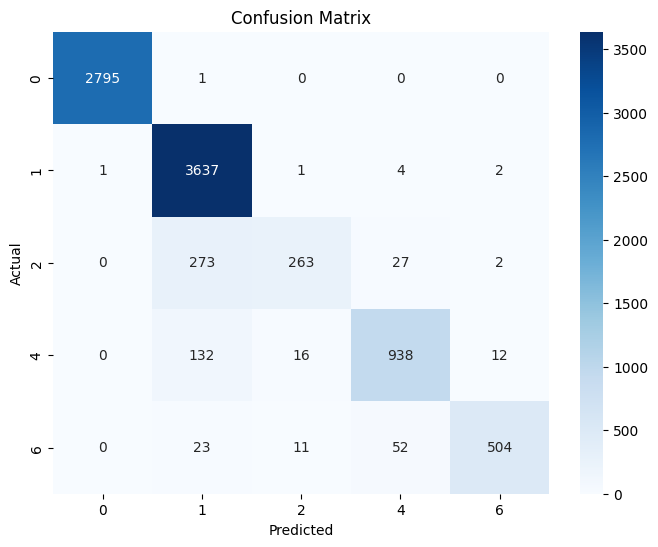

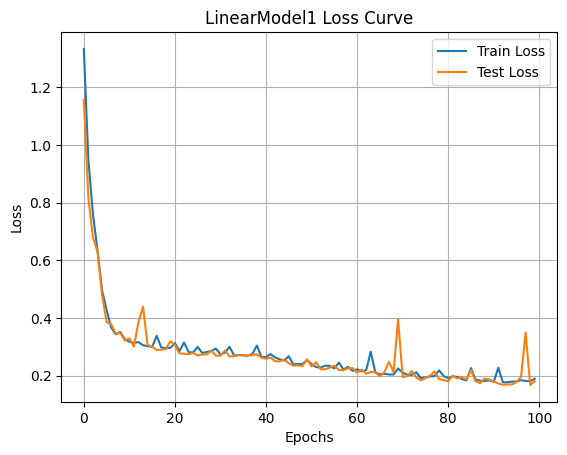

Time taken: 170.76 sec

Training CNN Model
Epoch 1, Train Loss: 1.3005, Test Loss: 1.1192
Epoch 5, Train Loss: 0.4902, Test Loss: 0.4370
Epoch 10, Train Loss: 0.4057, Test Loss: 0.3733
Epoch 15, Train Loss: 0.3626, Test Loss: 0.3450
Epoch 20, Train Loss: 0.3271, Test Loss: 0.2939
Epoch 25, Train Loss: 0.2737, Test Loss: 0.2899
Epoch 30, Train Loss: 0.2422, Test Loss: 0.2563
Epoch 35, Train Loss: 0.2473, Test Loss: 0.2238
Epoch 40, Train Loss: 0.2183, Test Loss: 0.2220
Epoch 45, Train Loss: 0.2065, Test Loss: 0.2284
Epoch 50, Train Loss: 0.1955, Test Loss: 0.2066
Epoch 55, Train Loss: 0.1926, Test Loss: 0.2118
Epoch 60, Train Loss: 0.1888, Test Loss: 0.1960
Epoch 65, Train Loss: 0.1821, Test Loss: 0.1946
Epoch 70, Train Loss: 0.1807, Test Loss: 0.1940
Epoch 75, Train Loss: 0.1718, Test Loss: 0.2072
Epoch 80, Train Loss: 0.1677, Test Loss: 0.1885
Epoch 85, Train Loss: 0.1626, Test Loss: 0.1801
Epoch 90, Train Loss: 0.1615, Test Loss: 0.1888
Epoch 95, Train Loss: 0.1558, Test Loss: 0.1700

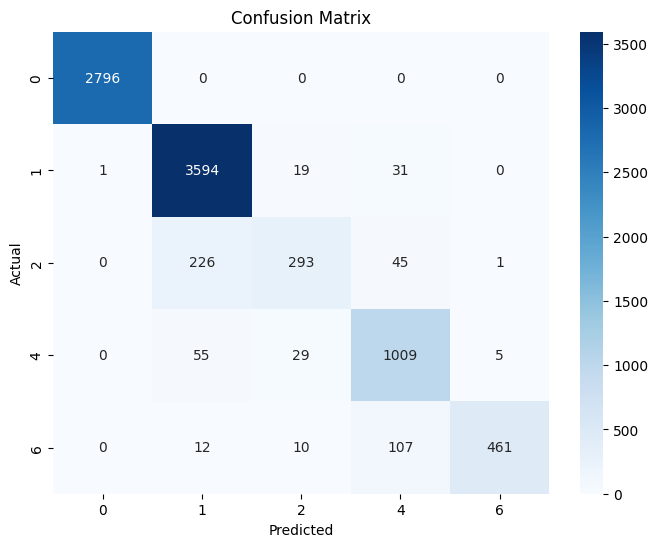

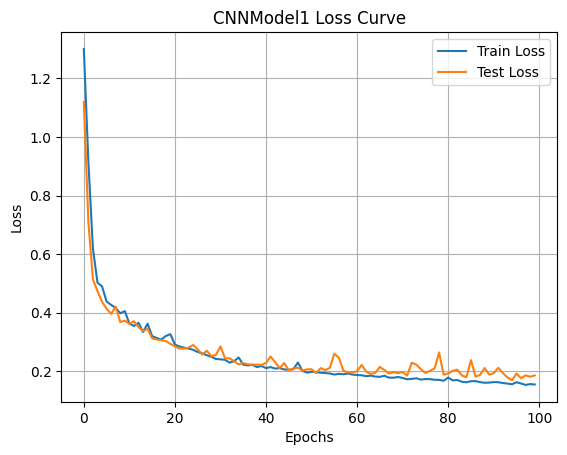

Time taken: 215.50 sec

Training RNN Model
Epoch 1, Train Loss: 1.2061, Test Loss: 0.8835
Epoch 5, Train Loss: 0.4057, Test Loss: 0.3799
Epoch 10, Train Loss: 0.3371, Test Loss: 0.3956
Epoch 15, Train Loss: 0.3064, Test Loss: 0.2846
Epoch 20, Train Loss: 0.2806, Test Loss: 0.2692
Epoch 25, Train Loss: 0.2709, Test Loss: 0.2637
Epoch 30, Train Loss: 0.2611, Test Loss: 0.2364
Epoch 35, Train Loss: 0.2572, Test Loss: 0.2462
Epoch 40, Train Loss: 0.2443, Test Loss: 0.2321
Epoch 45, Train Loss: 0.2334, Test Loss: 0.2545
Epoch 50, Train Loss: 0.2298, Test Loss: 0.2381
Epoch 55, Train Loss: 0.2345, Test Loss: 0.2176
Epoch 60, Train Loss: 0.2250, Test Loss: 0.2342
Epoch 65, Train Loss: 0.2229, Test Loss: 0.2285
Epoch 70, Train Loss: 0.2259, Test Loss: 0.2547
Epoch 75, Train Loss: 0.2258, Test Loss: 0.2046
Epoch 80, Train Loss: 0.2220, Test Loss: 0.2000
Epoch 85, Train Loss: 0.2206, Test Loss: 0.3458
Epoch 90, Train Loss: 0.2484, Test Loss: 0.2920
Epoch 95, Train Loss: 0.2259, Test Loss: 0.2891

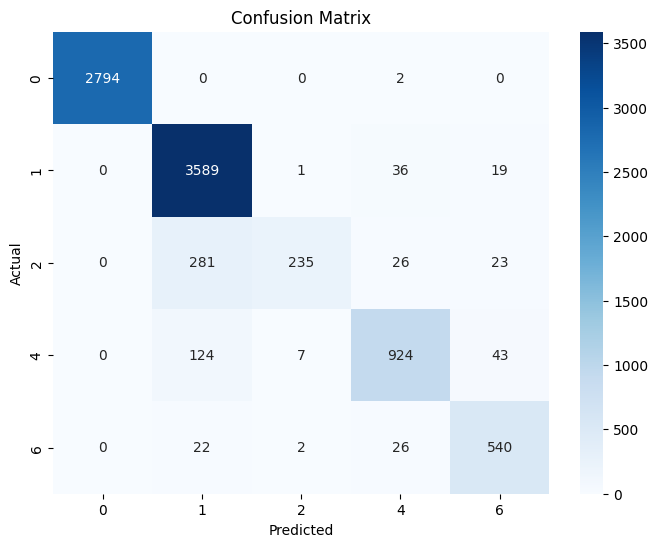

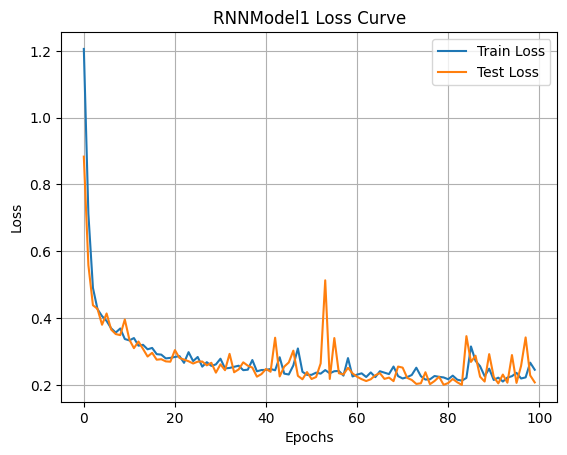

Time taken: 216.57 sec

Training LSTM Model
Epoch 1, Train Loss: 1.2190, Test Loss: 0.8659
Epoch 5, Train Loss: 0.3856, Test Loss: 0.3629
Epoch 10, Train Loss: 0.2994, Test Loss: 0.2836
Epoch 15, Train Loss: 0.2701, Test Loss: 0.2545
Epoch 20, Train Loss: 0.2393, Test Loss: 0.2386
Epoch 25, Train Loss: 0.2533, Test Loss: 0.2771
Epoch 30, Train Loss: 0.2243, Test Loss: 0.2171
Epoch 35, Train Loss: 0.2200, Test Loss: 0.2109
Epoch 40, Train Loss: 0.2200, Test Loss: 0.2116
Epoch 45, Train Loss: 0.2096, Test Loss: 0.2047
Epoch 50, Train Loss: 0.2100, Test Loss: 0.2051
Epoch 55, Train Loss: 0.2091, Test Loss: 0.2193
Epoch 60, Train Loss: 0.2159, Test Loss: 0.2032
Epoch 65, Train Loss: 0.2031, Test Loss: 0.1915
Epoch 70, Train Loss: 0.1994, Test Loss: 0.1949
Epoch 75, Train Loss: 0.2038, Test Loss: 0.1949
Epoch 80, Train Loss: 0.1991, Test Loss: 0.1833
Epoch 85, Train Loss: 0.1943, Test Loss: 0.1904
Epoch 90, Train Loss: 0.2001, Test Loss: 0.1925
Epoch 95, Train Loss: 0.1976, Test Loss: 0.201

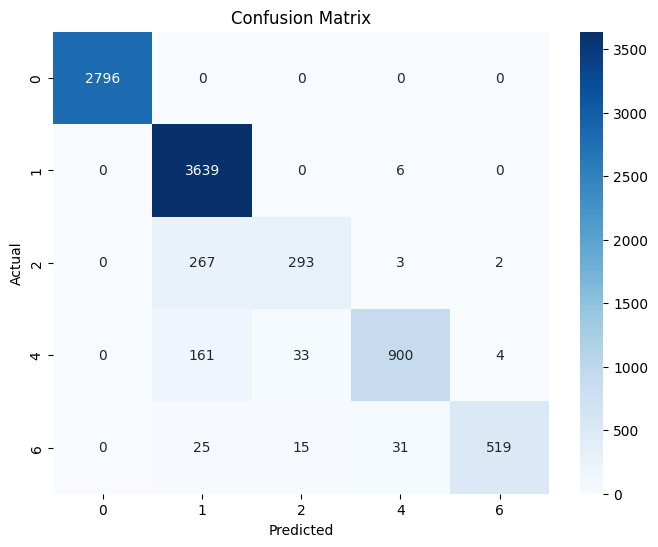

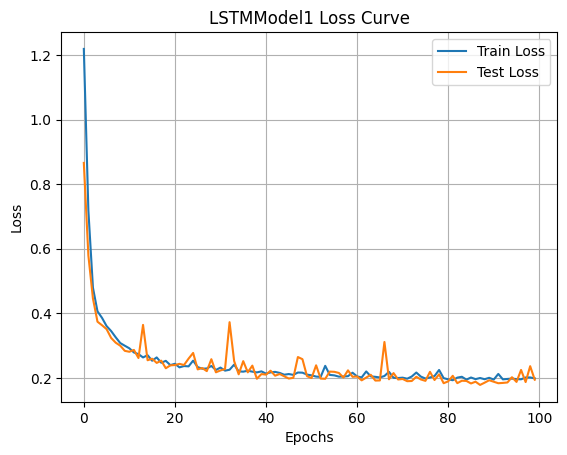

Time taken: 223.23 sec

Training GRU Model
Epoch 1, Train Loss: 1.0886, Test Loss: 0.6975
Epoch 5, Train Loss: 0.3742, Test Loss: 0.3791
Epoch 10, Train Loss: 0.3093, Test Loss: 0.2945
Epoch 15, Train Loss: 0.2825, Test Loss: 0.2879
Epoch 20, Train Loss: 0.2577, Test Loss: 0.2586
Epoch 25, Train Loss: 0.2415, Test Loss: 0.2301
Epoch 30, Train Loss: 0.2279, Test Loss: 0.2474
Epoch 35, Train Loss: 0.2229, Test Loss: 0.2103
Epoch 40, Train Loss: 0.2120, Test Loss: 0.2169
Epoch 45, Train Loss: 0.2136, Test Loss: 0.1999
Epoch 50, Train Loss: 0.2241, Test Loss: 0.2017
Epoch 55, Train Loss: 0.2104, Test Loss: 0.1934
Epoch 60, Train Loss: 0.2064, Test Loss: 0.2039
Epoch 65, Train Loss: 0.2178, Test Loss: 0.1917
Epoch 70, Train Loss: 0.1978, Test Loss: 0.1967
Epoch 75, Train Loss: 0.2137, Test Loss: 0.2052
Epoch 80, Train Loss: 0.1990, Test Loss: 0.1842
Epoch 85, Train Loss: 0.2028, Test Loss: 0.1837
Epoch 90, Train Loss: 0.1999, Test Loss: 0.2037
Epoch 95, Train Loss: 0.1947, Test Loss: 0.2035

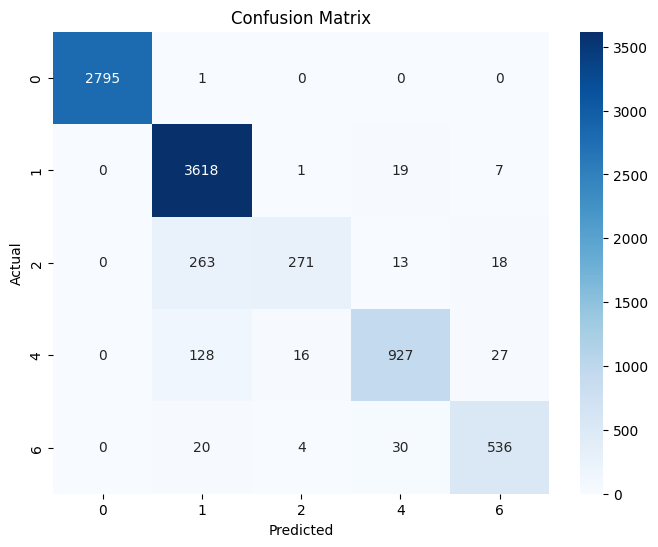

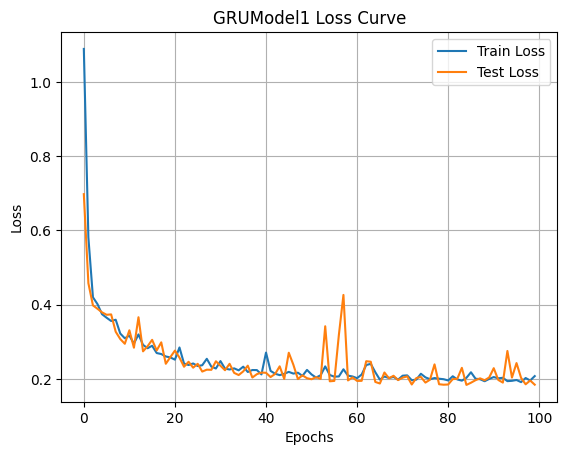

Time taken: 193.80 sec

Training BiLSTM Model
Epoch 1, Train Loss: 1.3482, Test Loss: 1.2607
Epoch 5, Train Loss: 0.4582, Test Loss: 0.4327
Epoch 10, Train Loss: 0.3560, Test Loss: 0.3433
Epoch 15, Train Loss: 0.3013, Test Loss: 0.2972
Epoch 20, Train Loss: 0.2785, Test Loss: 0.2766
Epoch 25, Train Loss: 0.2600, Test Loss: 0.2557
Epoch 30, Train Loss: 0.2494, Test Loss: 0.2451
Epoch 35, Train Loss: 0.2375, Test Loss: 0.2342
Epoch 40, Train Loss: 0.2329, Test Loss: 0.2465
Epoch 45, Train Loss: 0.2241, Test Loss: 0.2185
Epoch 50, Train Loss: 0.2167, Test Loss: 0.2098
Epoch 55, Train Loss: 0.2130, Test Loss: 0.2084
Epoch 60, Train Loss: 0.2106, Test Loss: 0.2110
Epoch 65, Train Loss: 0.2111, Test Loss: 0.1987
Epoch 70, Train Loss: 0.2027, Test Loss: 0.2027
Epoch 75, Train Loss: 0.2048, Test Loss: 0.2007
Epoch 80, Train Loss: 0.2003, Test Loss: 0.1920
Epoch 85, Train Loss: 0.1973, Test Loss: 0.1926
Epoch 90, Train Loss: 0.1979, Test Loss: 0.2138
Epoch 95, Train Loss: 0.2203, Test Loss: 0.1

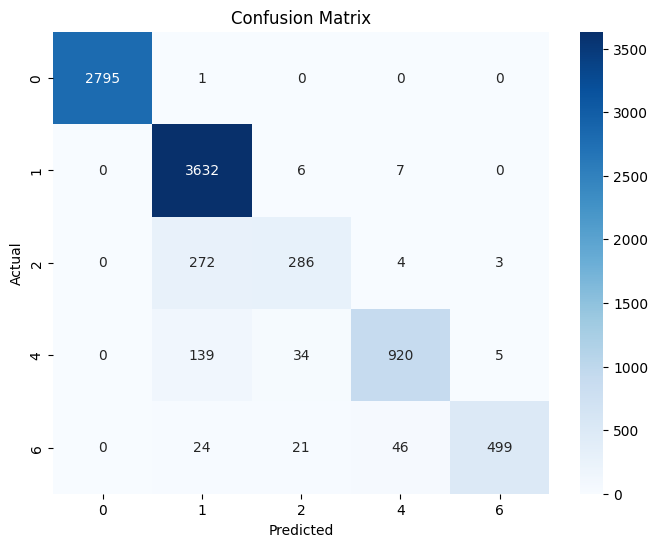

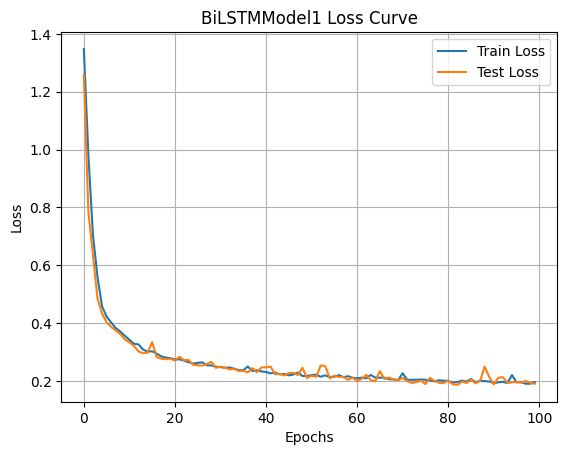

Time taken: 185.04 sec

Training Transformer Model


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Train Loss: 1.3622, Test Loss: 1.3516
Epoch 5, Train Loss: 0.9140, Test Loss: 0.8974
Epoch 10, Train Loss: 0.5990, Test Loss: 0.7538
Epoch 15, Train Loss: 0.4066, Test Loss: 0.4101
Epoch 20, Train Loss: 0.3585, Test Loss: 0.2941
Epoch 25, Train Loss: 0.3264, Test Loss: 0.2771
Epoch 30, Train Loss: 0.2990, Test Loss: 0.3148
Epoch 35, Train Loss: 0.2937, Test Loss: 0.2401
Epoch 40, Train Loss: 0.2717, Test Loss: 0.2400
Epoch 45, Train Loss: 0.2679, Test Loss: 0.2586
Epoch 50, Train Loss: 0.3047, Test Loss: 0.2525
Epoch 55, Train Loss: 0.2608, Test Loss: 0.2119
Epoch 60, Train Loss: 0.2448, Test Loss: 0.2134
Epoch 65, Train Loss: 0.2521, Test Loss: 0.2119
Epoch 70, Train Loss: 0.2711, Test Loss: 0.2137
Epoch 75, Train Loss: 0.2360, Test Loss: 0.2191
Epoch 80, Train Loss: 0.2334, Test Loss: 0.2181
Epoch 85, Train Loss: 0.2412, Test Loss: 0.2195
Epoch 90, Train Loss: 0.2185, Test Loss: 0.1912
Epoch 95, Train Loss: 0.2218, Test Loss: 0.1834
Epoch 100, Train Loss: 0.2206, Test Loss: 

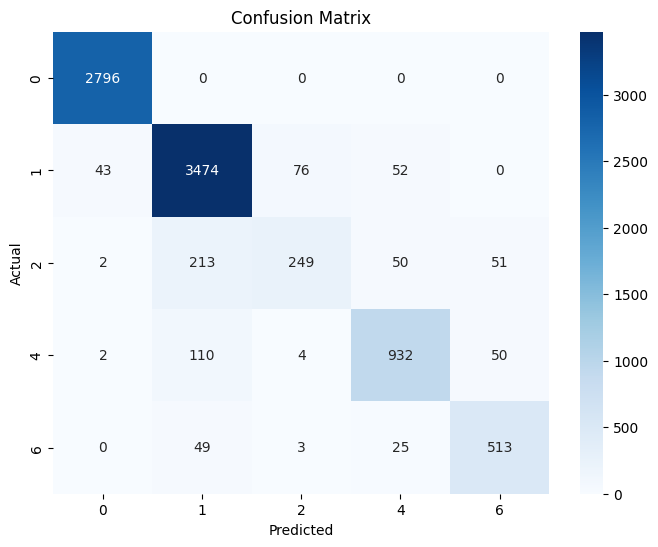

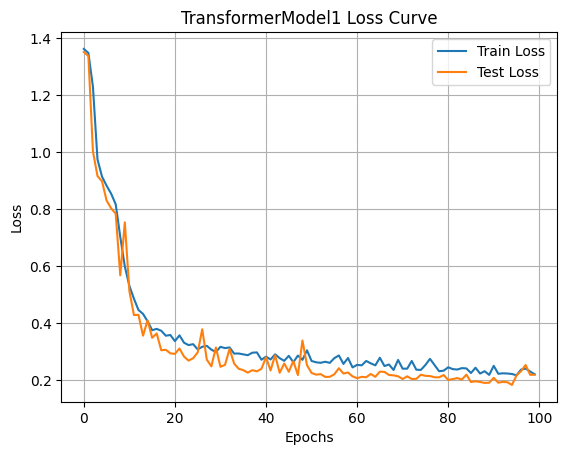

Time taken: 446.73 sec


In [43]:
for name, model_cls in model_dict1.items():
    print(f"\n{'='*30}\nTraining {name} Model\n{'='*30}")
    model = model_cls(input_dim=x_train.shape[1], num_classes=5).to(device)
    start_time = time.time()
    train_and_evaluate1(model, train_loader, test_loader)
    print(f"Time taken: {time.time() - start_time:.2f} sec")